## Anomaly Detection using LSTM-Variational Autoencoder

In [12]:
# Imports
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [13]:
# Set paths
base_path = Path(r"C:\Users\House\OneDrive\Documents\Sohan_Arun\BTH Course Work\Deep Learning\Assignment 2")
data_path = base_path / "data"

# Model parameters
WINDOW_SIZE = 10
STRIDE = 5
HIDDEN_DIM = 128
LATENT_DIM = 32
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATIENCE = 10
MIN_ANOMALY_WINDOWS = 100

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
class LSTM_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32, sequence_length=250):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.sequence_length = sequence_length
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n.squeeze(0)
        return self.mu(h_n), self.log_var(h_n)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z_repeated = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
        output, _ = self.decoder_lstm(z_repeated)
        return self.output_layer(output)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [ ]:
def get_channel_names(base_path=Path(".")):
    """
    Get channel names from train directory

    """
    train_path = base_path / "data" / "train"
    channels = [f.stem for f in train_path.glob("*.npy")]  # stem removes .npy extension
    return sorted(channels)


def create_sliding_windows(data, window_size):
    windows = []
    stride = window_size // 2 
    
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i + window_size])
    return np.array(windows)



def load_and_preprocess_data(channel_name, base_path):
    """
    Load and preprocess data for a channel using real anomaly labels

    """
    # Load data
    train_data = np.load(base_path / "data" / "train" / f"{channel_name}.npy")
    test_data = np.load(base_path / "data" / "test" / f"{channel_name}.npy")
    

    
    # Load real anomaly labels
    labels_df = pd.read_csv(base_path / "data" / "labeled_anomalies.csv")
    
    # Filter labels for current channel using chan_id
    channel_labels = labels_df[labels_df['chan_id'] == channel_name]
    
        # Skip if no labels found
    if channel_labels.empty:
        print(f"\n⚠️ WARNING: No labels found for channel {channel_name}")
        print("→ Skipping channel")
        return None
    
    # Continue processing if labels exist
    channel_info = channel_labels.iloc[0]
    
    
    # Scale data
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    
    # Create windows
    train_windows = create_sliding_windows(train_data, window_size=WINDOW_SIZE)
    test_windows = create_sliding_windows(test_data, window_size=WINDOW_SIZE)

    
    # Create label array matching the windowed data
    test_labels = np.zeros(len(test_windows))
    
    # Parse anomaly sequences and mark windows
    sequences = eval(channel_info['anomaly_sequences'])
    for start, end in sequences:
        # Convert sequence indices to window indices
        window_start = start // STRIDE
        window_end = end // STRIDE
        test_labels[window_start:window_end + 1] = 1
        
        
    print(f"Channel {channel_name}:")
    print(f"Total windows: {len(test_windows)}")
    print(f"Anomaly windows: {int(test_labels.sum())}")
    print(f"Anomaly class: {channel_labels['class']}")
    
    return train_windows, test_windows, test_labels, scaler

In [ ]:
def train_model(model, train_loader, val_loader, device, channel_name, scaler, patience=PATIENCE):
    """
    Train the LSTM-VAE model and save checkpoints
    """

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=patience, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            
            optimizer.zero_grad()
            x_hat, mu, log_var = model(x)
            
            recon_loss = nn.MSELoss()(x_hat, x)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            loss = recon_loss + 0.1 * kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                x_hat, mu, log_var = model(x)
                
                recon_loss = nn.MSELoss()(x_hat, x)
                kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                val_loss += (recon_loss + 0.1 * kl_loss).item()
        
        val_loss = val_loss / len(val_loader)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Checkpoint saving logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break
    
    return best_val_loss

In [18]:
def plot_metrics(channel_name, anomaly_scores, threshold, test_labels, predicted_labels):
    """Plot evaluation metrics including AUPRC"""
    

    # Create a 2x2 subplot figure
    plt.figure(figsize=(15, 12))
    
    # First subplot - Anomaly Scores
    plt.subplot(2, 2, 1)
    plt.plot(anomaly_scores, label='Anomaly Score')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    
    # Add red dots for true anomalies
    anomaly_indices = np.where(test_labels == 1)[0]
    plt.scatter(anomaly_indices, anomaly_scores[anomaly_indices], 
                color='red', s=40, marker='o', label='True Anomalies')
    
    plt.title(f'Anomaly Scores - {channel_name}')
    plt.legend()
    
    # Second subplot - Confusion matrix
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {channel_name}')
    
    # Third subplot - ROC curve
    plt.subplot(2, 2, 3)
    auroc = roc_auc_score(test_labels, anomaly_scores)
    fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
    plt.plot(fpr, tpr, label=f'AUC = {auroc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Fourth subplot - Precision-Recall curve
    plt.subplot(2, 2, 4)
    auprc = average_precision_score(test_labels, anomaly_scores)
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, anomaly_scores)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.3f}')
    
    # Add baseline (no-skill classifier line)
    baseline = sum(test_labels)/len(test_labels)
    plt.axhline(y=baseline, color='r', linestyle='--', 
               label=f'Baseline = {baseline:.4f}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\nMetrics:")
    print(f"Accuracy: {accuracy_score(test_labels, predicted_labels):.3f}")
    print(f"Precision: {precision_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"Recall: {recall_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"F1: {f1_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"AUROC: {auroc:.3f}")
    print(f"AUPRC: {auprc:.3f} (Baseline: {baseline:.4f})")

In [ ]:
def process_all_channels(base_path=base_path, min_anomaly_windows=MIN_ANOMALY_WINDOWS):
    """Process all channels found in both train and test directories"""
    channels = get_channel_names(base_path)
    results = {}
    skipped_channels = []
    
    
    for channel in channels:
        print(f"\n{'='*50}")
        print(f"Processing channel {channel}")
        print(f"{'='*50}")
        
        # Load and preprocess data
        preprocessing_result = load_and_preprocess_data(channel, base_path)
        
        # Skip if preprocessing returned None
        if preprocessing_result is None:
            skipped_channels.append({
                'channel': channel,
                'reason': 'No labels found'
            })
            continue
            
        # Unpack results if preprocessing was successful
        train_windows, test_windows, test_labels, scaler = preprocessing_result
        
       
        
        # Check for minimum anomaly windows
        anomaly_count = int(test_labels.sum())
        if anomaly_count < min_anomaly_windows:
            skipped_channels.append({
                'channel': channel,
                'anomaly_count': anomaly_count,
                'reason': f'Insufficient anomaly windows (minimum {min_anomaly_windows} required)'
            })
            print(f"\n⚠️ WARNING: Skipping channel {channel}")
            print(f"Found only {anomaly_count} anomaly windows (minimum {min_anomaly_windows} required)")
            continue
        
        
        # Create data loaders
        train_windows, val_windows = train_test_split(train_windows, test_size=0.2)
        train_loader = DataLoader(TensorDataset(torch.FloatTensor(train_windows)), 
                                batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.FloatTensor(val_windows)), 
                              batch_size=BATCH_SIZE)
        
        # Create and train model
        input_dim = train_windows.shape[2]
        model = LSTM_VAE(input_dim=input_dim,          
                         hidden_dim=HIDDEN_DIM,
                        latent_dim=LATENT_DIM,
                        sequence_length=WINDOW_SIZE 
                        ).to(device)
        
        train_model(model, train_loader, val_loader, device, channel, scaler, PATIENCE)
        
        # Get predictions
        model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_windows).to(device)
            reconstructed, _, _ = model(test_tensor)
            reconstruction_errors = torch.mean((test_tensor - reconstructed) ** 2, dim=(1,2))
        
        # Calculate threshold and predictions
        anomaly_scores = reconstruction_errors.cpu().numpy()
        threshold = np.percentile(anomaly_scores, 70)
        predicted_labels = (anomaly_scores > threshold).astype(int)
        
        # Plot results
        plot_metrics(channel, anomaly_scores, threshold, test_labels, predicted_labels)
        
        results[channel] = {
            'scores': anomaly_scores,
            'predictions': predicted_labels,
            'labels': test_labels
        }
    
    return results
        


Processing channel A-1
Channel A-1:
Total windows: 1727
Anomaly windows: 17
Anomaly class: 15    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-1
Found only 17 anomaly windows (minimum 100 required)

Processing channel A-2
Channel A-2:
Total windows: 1581
Anomaly windows: 23
Anomaly class: 22    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-2
Found only 23 anomaly windows (minimum 100 required)

Processing channel A-3
Channel A-3:
Total windows: 1640
Anomaly windows: 38
Anomaly class: 23    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-3
Found only 38 anomaly windows (minimum 100 required)

Processing channel A-4
Channel A-4:
Total windows: 1615
Anomaly windows: 23
Anomaly class: 24    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-4
Found only 23 anomaly windows (minimum 100 required)

Processing channel A-5
Channel A-5:
Total windows: 937
Anomaly windows: 11
Anomaly class: 47    [point]


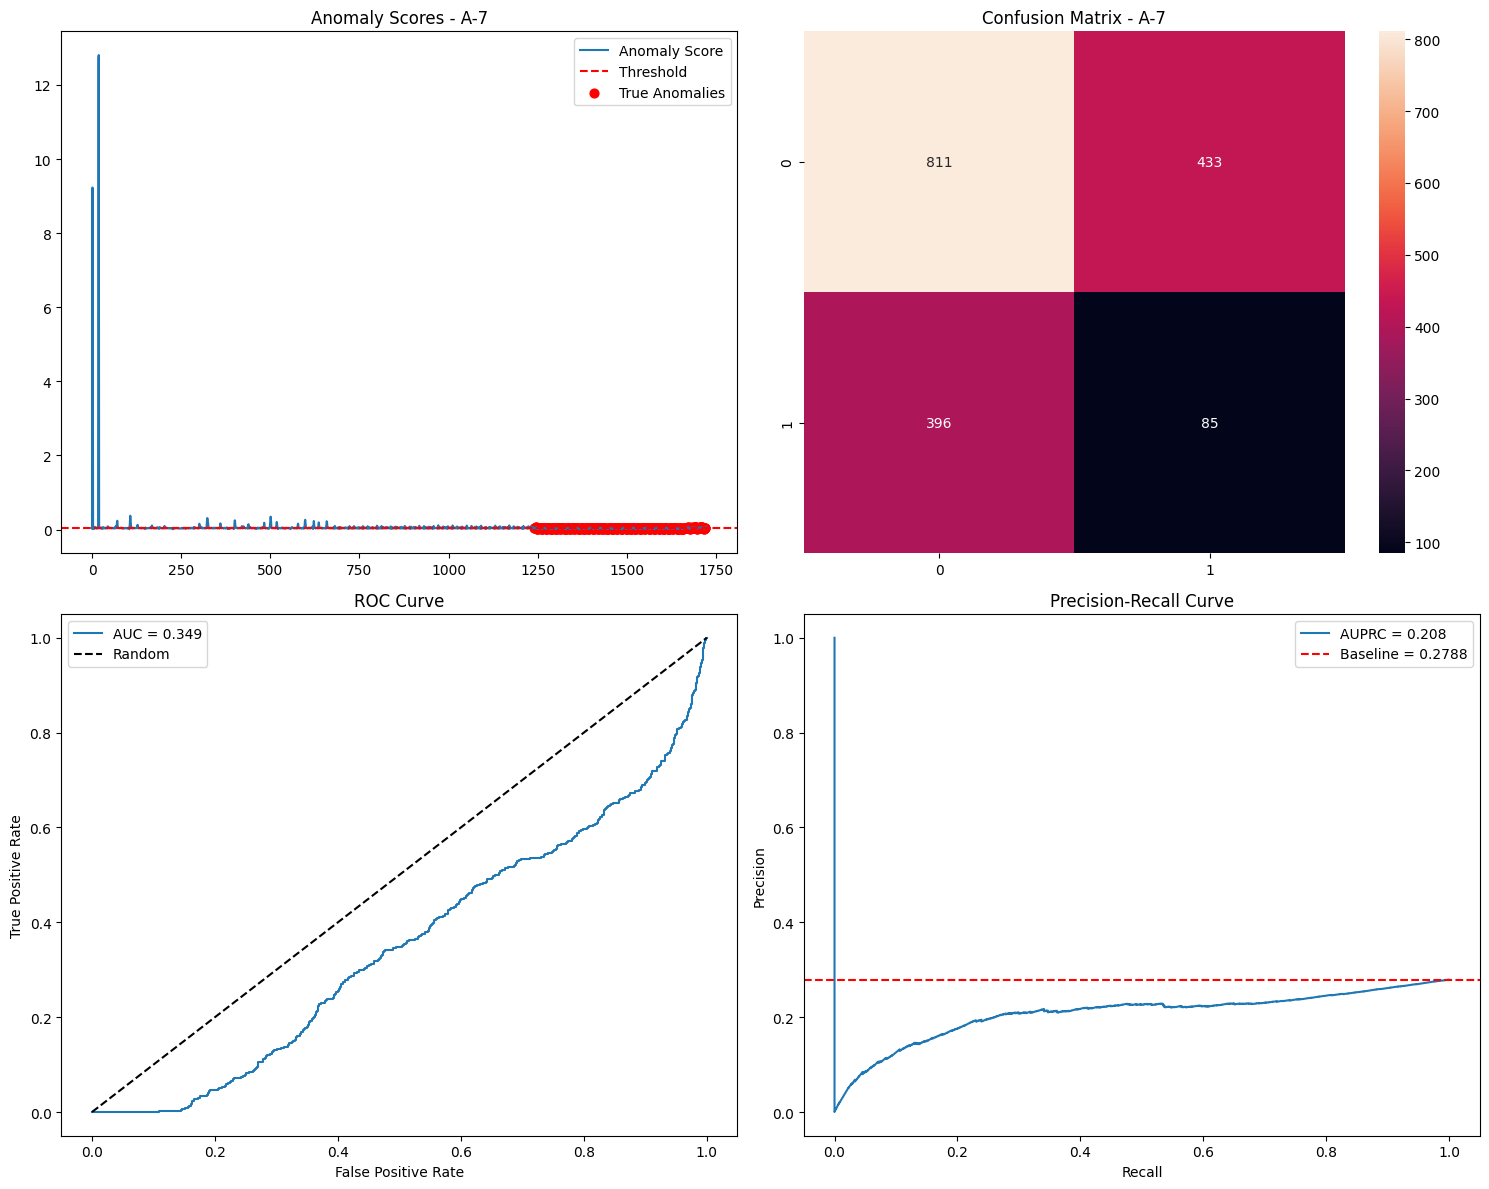


Metrics:
Accuracy: 0.519
Precision: 0.164
Recall: 0.177
F1: 0.170
AUROC: 0.349
AUPRC: 0.208 (Baseline: 0.2788)

Processing channel A-8
Channel A-8:
Total windows: 1674
Anomaly windows: 761
Anomaly class: 52    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.5902, Val Loss: 0.6445
Epoch 2, Train Loss: 0.4442, Val Loss: 0.5599
Epoch 3, Train Loss: 0.4168, Val Loss: 0.5440
Epoch 4, Train Loss: 0.4035, Val Loss: 0.5363
Epoch 5, Train Loss: 0.3841, Val Loss: 0.5301
Epoch 6, Train Loss: 0.3792, Val Loss: 0.5301
Epoch 7, Train Loss: 0.3594, Val Loss: 0.5314
Epoch 8, Train Loss: 0.3763, Val Loss: 0.5292
Epoch 9, Train Loss: 0.3816, Val Loss: 0.5282
Epoch 10, Train Loss: 0.3668, Val Loss: 0.5298
Epoch 11, Train Loss: 0.3541, Val Loss: 0.5263
Epoch 12, Train Loss: 0.3570, Val Loss: 0.5299
Epoch 13, Train Loss: 0.3644, Val Loss: 0.5244
Epoch 14, Train Loss: 0.3902, Val Loss: 0.5277
Epoch 15, Train Loss: 0.3547, Val Loss: 0.5265
Epoch 16, Train Loss: 0.4112, Val Loss: 0.5283
Epoch 

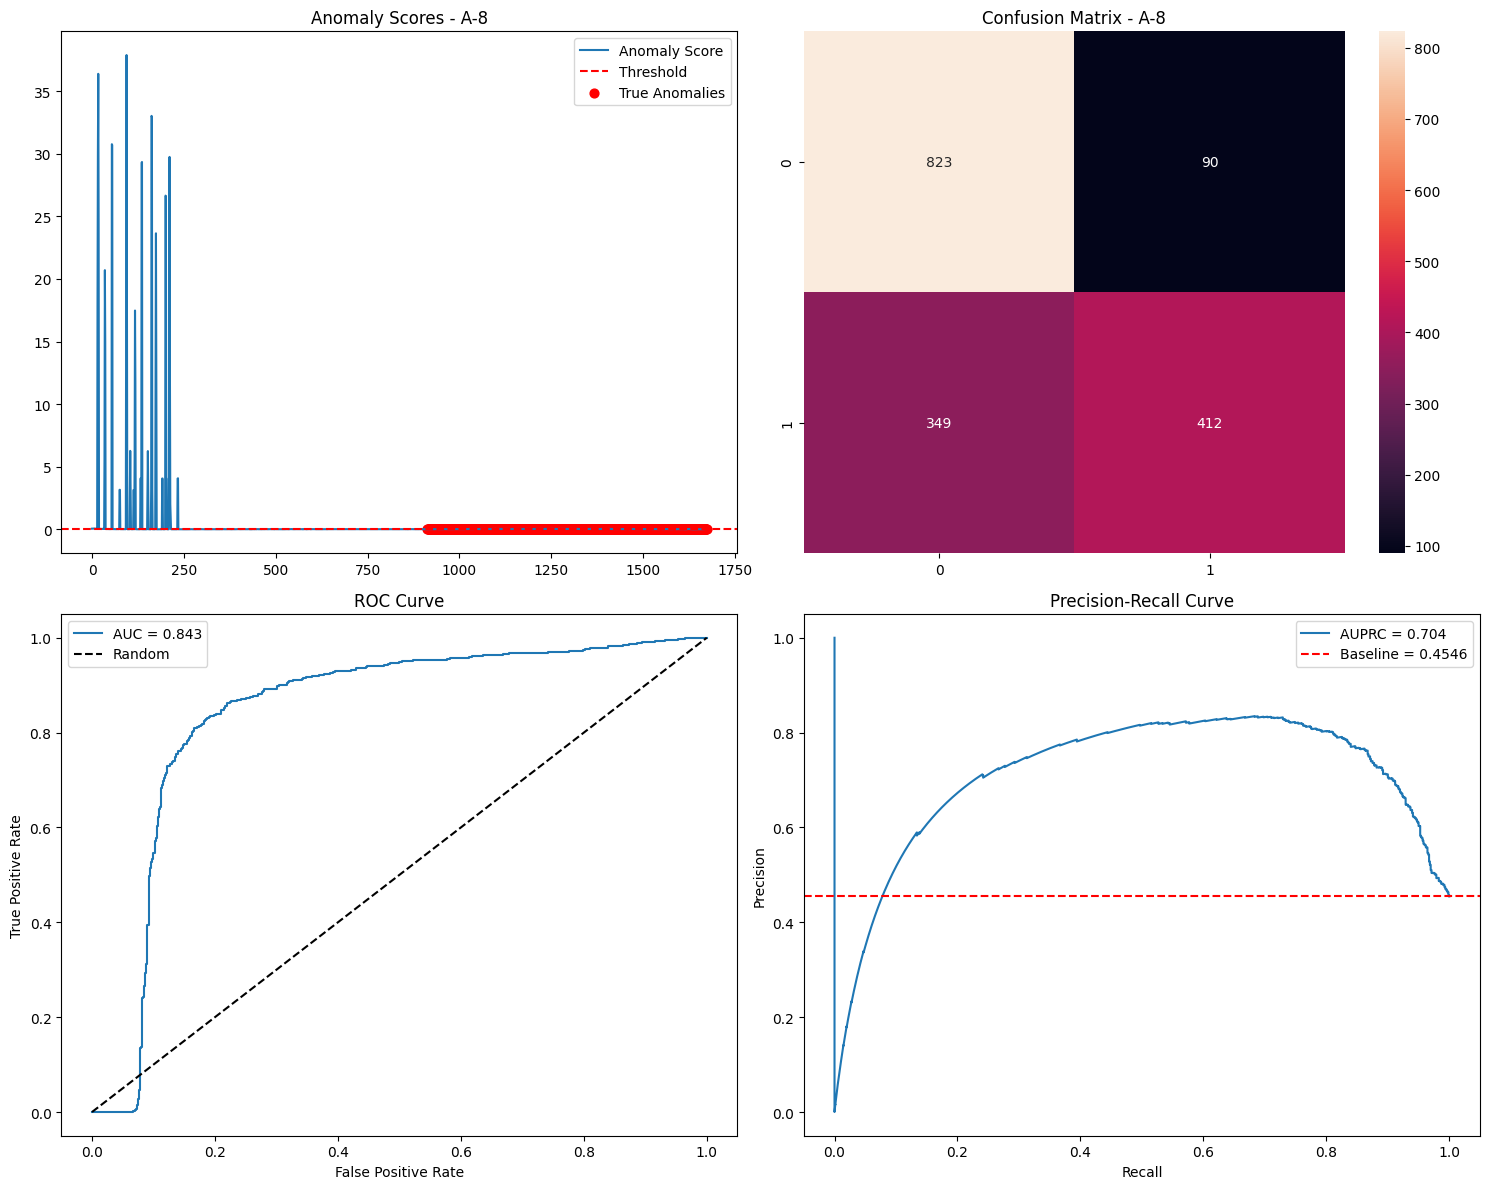


Metrics:
Accuracy: 0.738
Precision: 0.821
Recall: 0.541
F1: 0.652
AUROC: 0.843
AUPRC: 0.704 (Baseline: 0.4546)

Processing channel A-9
Channel A-9:
Total windows: 1685
Anomaly windows: 772
Anomaly class: 53    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.5280, Val Loss: 0.7960
Epoch 2, Train Loss: 0.4070, Val Loss: 0.7287
Epoch 3, Train Loss: 0.3414, Val Loss: 0.7242
Epoch 4, Train Loss: 0.3457, Val Loss: 0.7114
Epoch 5, Train Loss: 0.3292, Val Loss: 0.7155
Epoch 6, Train Loss: 0.3357, Val Loss: 0.7079
Epoch 7, Train Loss: 0.3402, Val Loss: 0.7096
Epoch 8, Train Loss: 0.3533, Val Loss: 0.7138
Epoch 9, Train Loss: 0.3650, Val Loss: 0.7059
Epoch 10, Train Loss: 0.3296, Val Loss: 0.7058
Epoch 11, Train Loss: 0.3385, Val Loss: 0.7057
Epoch 12, Train Loss: 0.3224, Val Loss: 0.7052
Epoch 13, Train Loss: 0.3380, Val Loss: 0.7058
Epoch 14, Train Loss: 0.3391, Val Loss: 0.7032
Epoch 15, Train Loss: 0.3376, Val Loss: 0.7030
Epoch 16, Train Loss: 0.3213, Val Loss: 0.7035
Epoch 

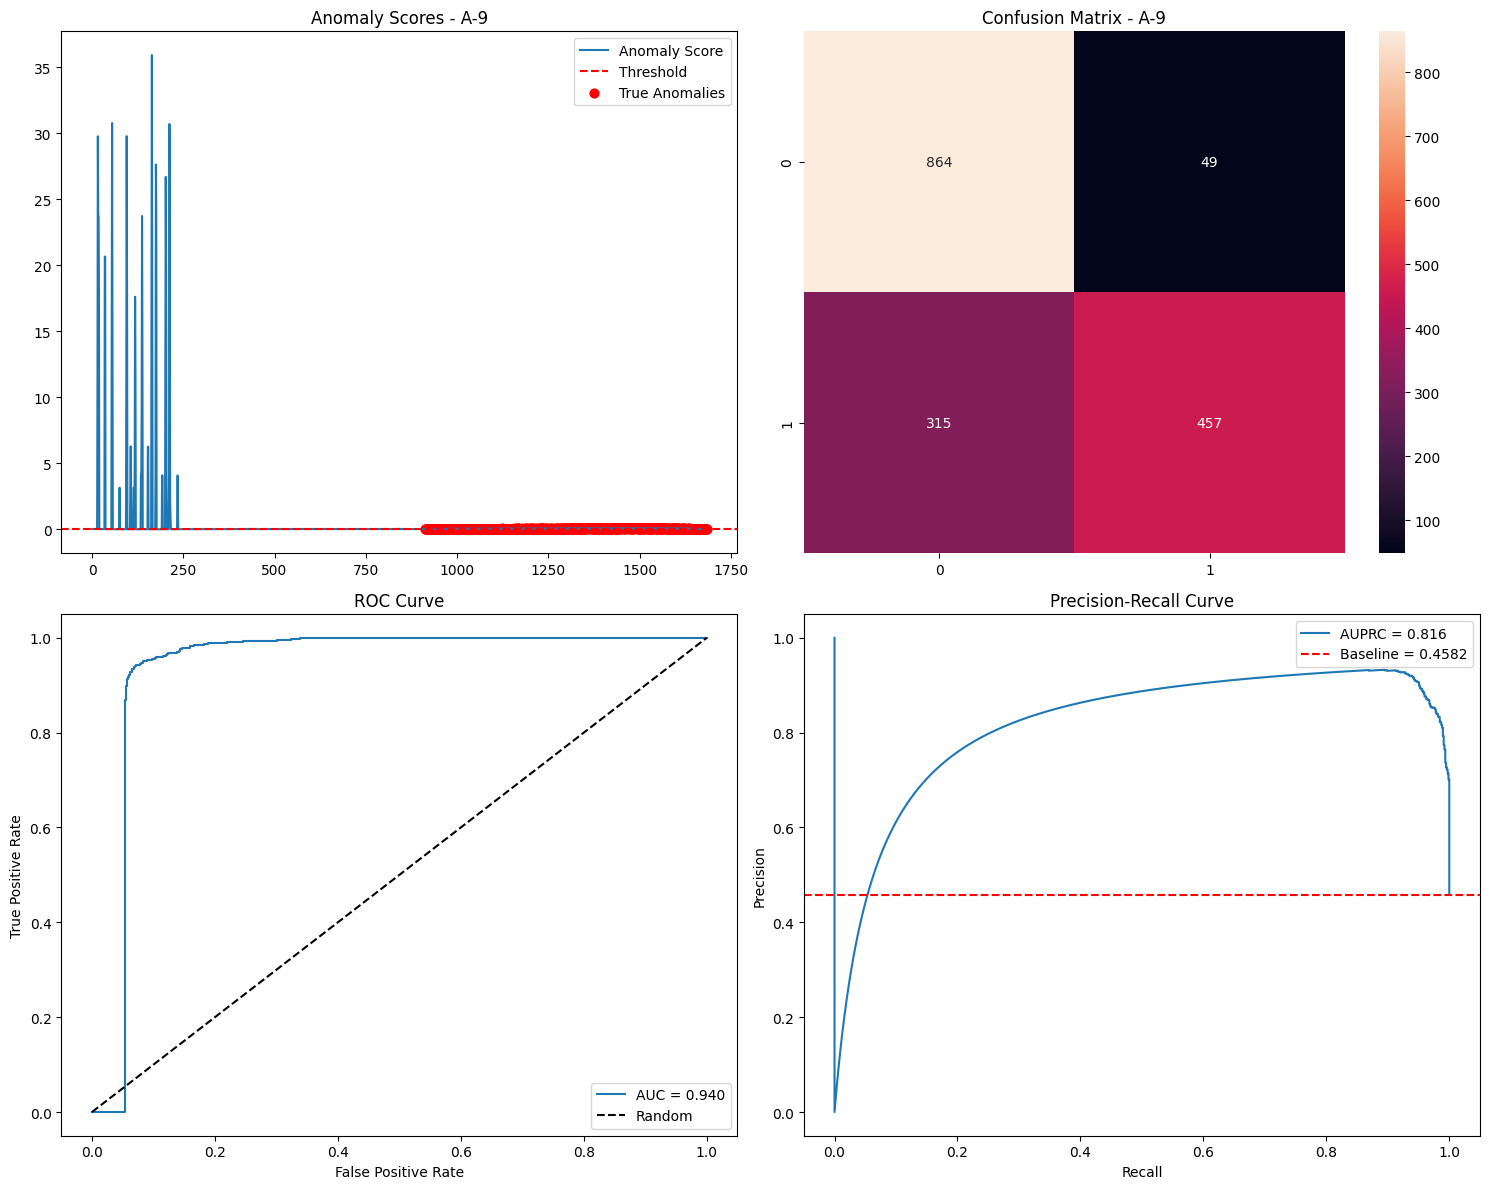


Metrics:
Accuracy: 0.784
Precision: 0.903
Recall: 0.592
F1: 0.715
AUROC: 0.940
AUPRC: 0.816 (Baseline: 0.4582)

Processing channel B-1
Channel B-1:
Total windows: 1607
Anomaly windows: 15
Anomaly class: 42    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel B-1
Found only 15 anomaly windows (minimum 100 required)

Processing channel C-1
Channel C-1:
Total windows: 451
Anomaly windows: 64
Anomaly class: 67    [point, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel C-1
Found only 64 anomaly windows (minimum 100 required)

Processing channel C-2
Channel C-2:
Total windows: 409
Anomaly windows: 29
Anomaly class: 68    [point, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel C-2
Found only 29 anomaly windows (minimum 100 required)

Processing channel D-1
Channel D-1:
Total windows: 1700
Anomaly windows: 650
Anomaly class: 16    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7765, Val Loss: 0.8008
Epoch 2, Train Loss: 0.685

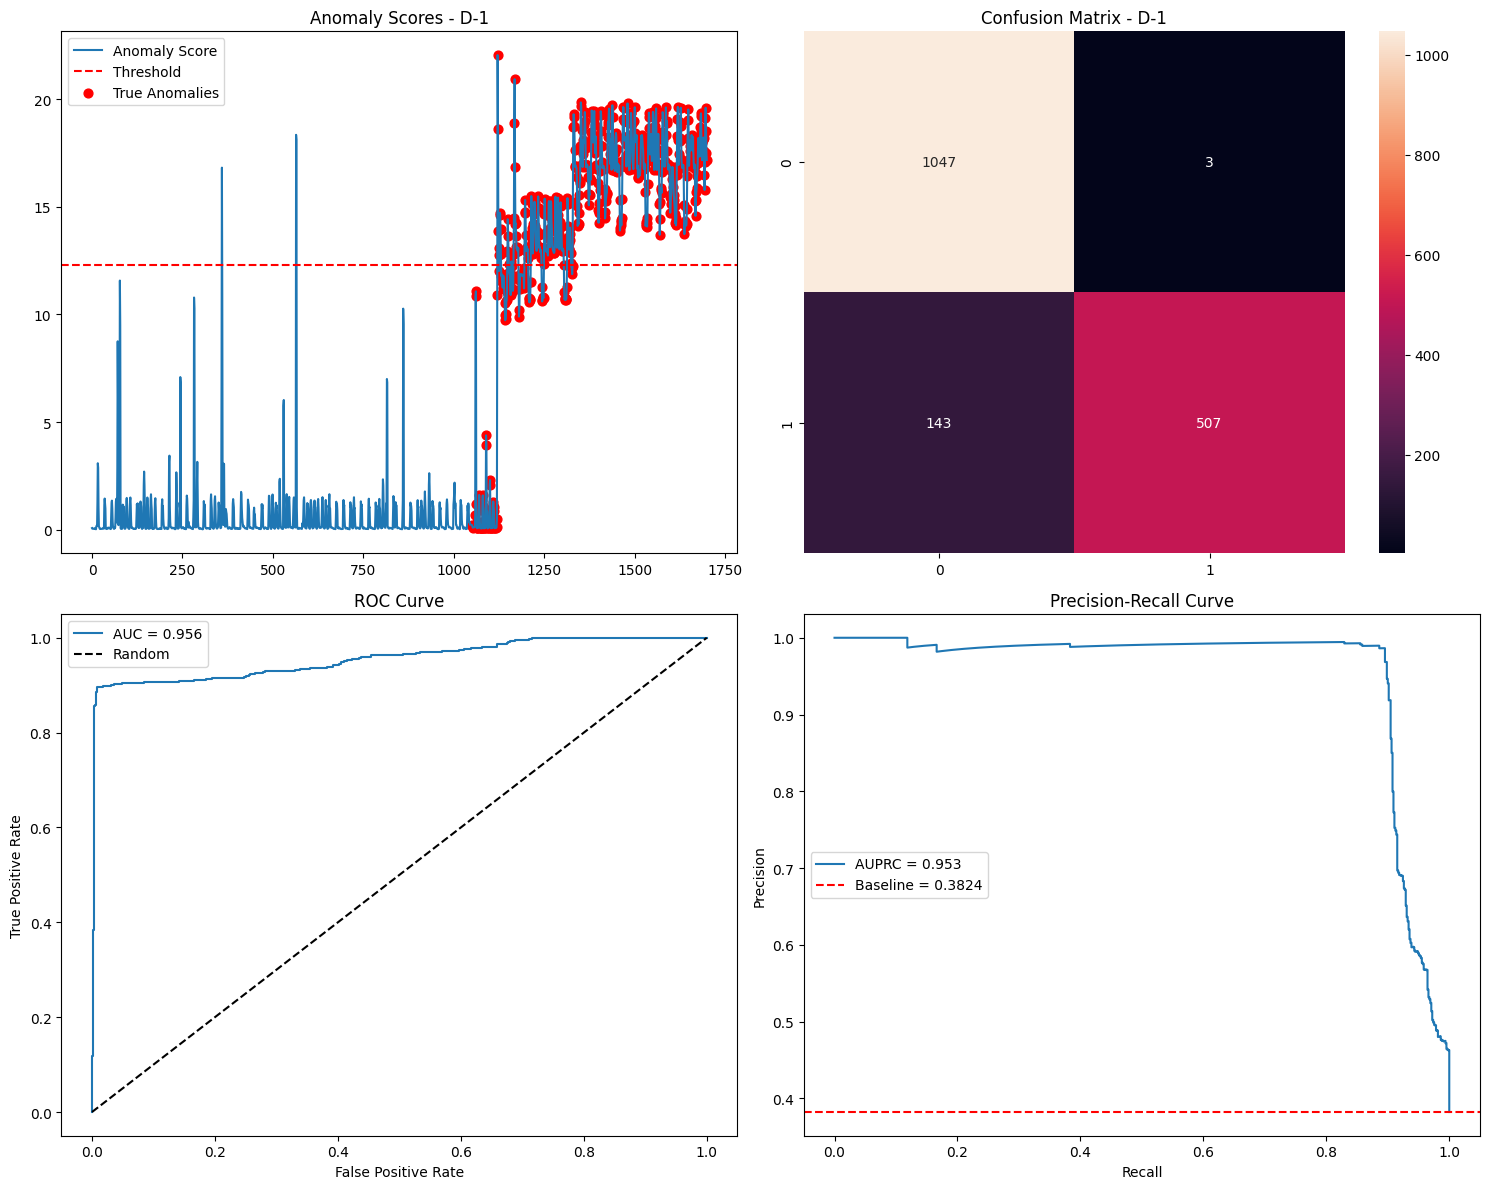


Metrics:
Accuracy: 0.914
Precision: 0.994
Recall: 0.780
F1: 0.874
AUROC: 0.956
AUPRC: 0.953 (Baseline: 0.3824)

Processing channel D-11
Channel D-11:
Total windows: 1485
Anomaly windows: 13
Anomaly class: 40    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-11
Found only 13 anomaly windows (minimum 100 required)

Processing channel D-12
Channel D-12:
Total windows: 1582
Anomaly windows: 547
Anomaly class: 41    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.2106, Val Loss: 0.0835
Epoch 2, Train Loss: 0.1376, Val Loss: 0.0514
Epoch 3, Train Loss: 0.0841, Val Loss: 0.0293
Epoch 4, Train Loss: 0.0457, Val Loss: 0.0142
Epoch 5, Train Loss: 0.0223, Val Loss: 0.0087
Epoch 6, Train Loss: 0.0137, Val Loss: 0.0075
Epoch 7, Train Loss: 0.0120, Val Loss: 0.0058
Epoch 8, Train Loss: 0.0093, Val Loss: 0.0041
Epoch 9, Train Loss: 0.0060, Val Loss: 0.0028
Epoch 10, Train Loss: 0.0044, Val Loss: 0.0024
Epoch 11, Train Loss: 0.0040, Val Loss: 0.0023
Epoch 12, Train Loss:

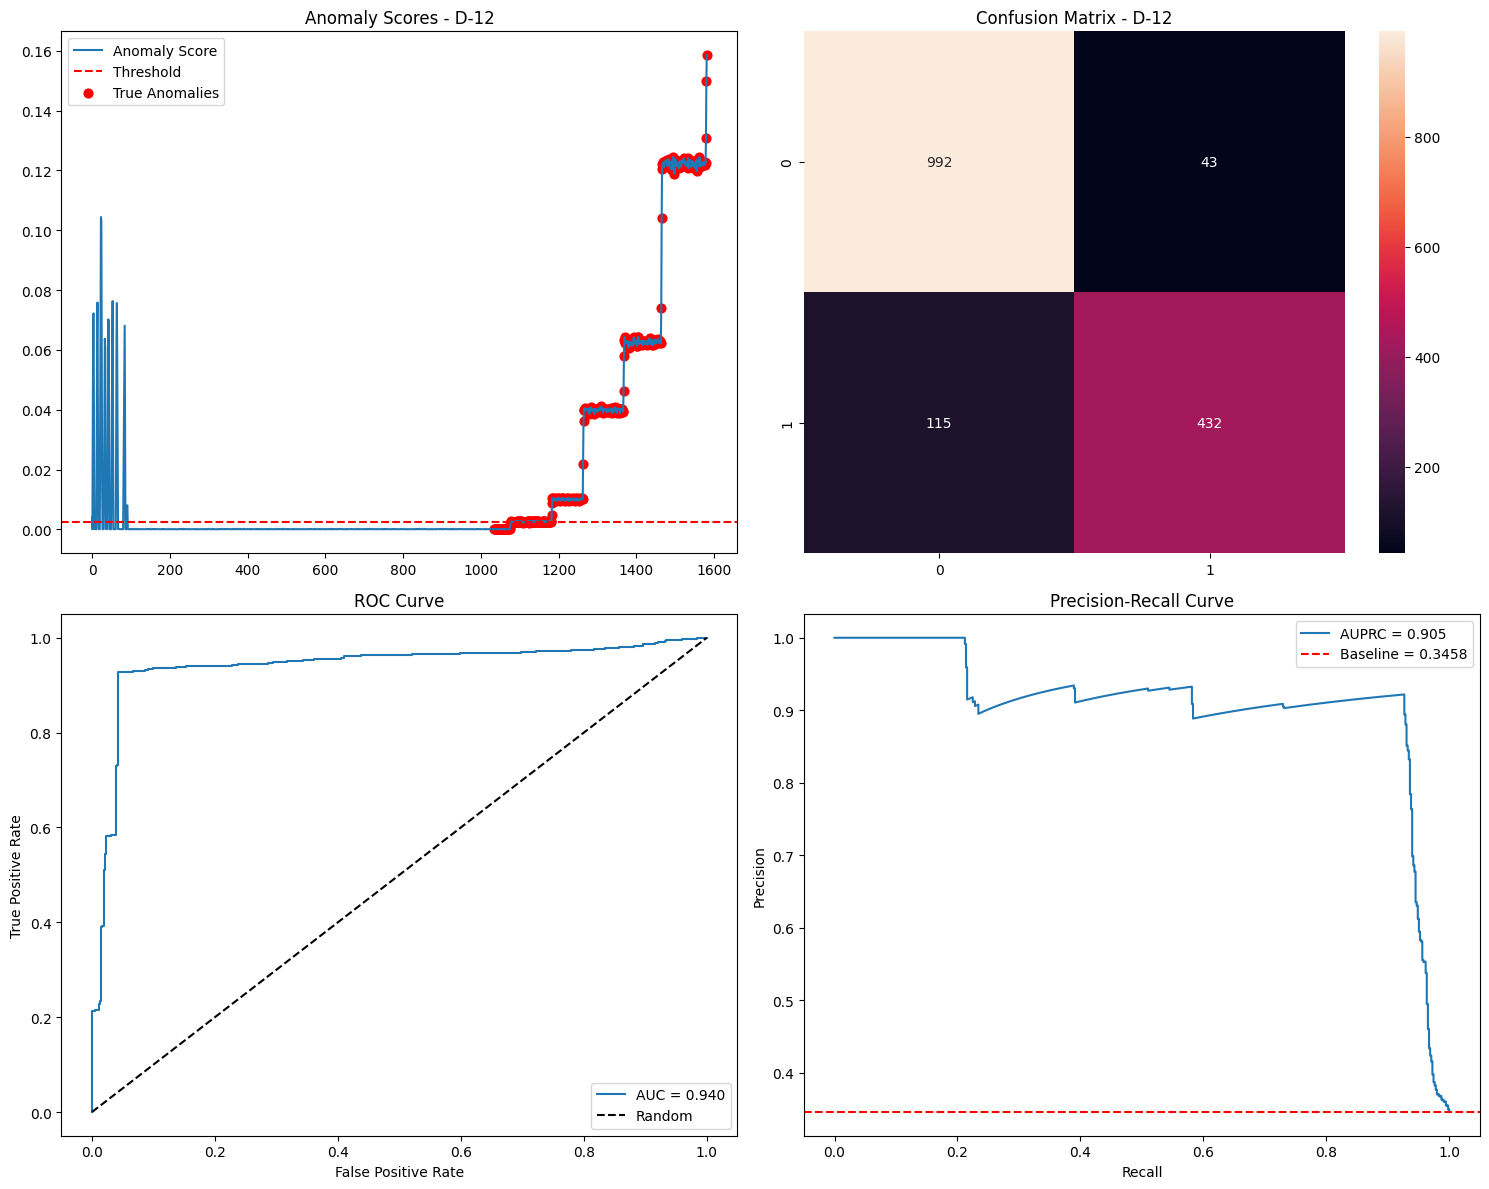


Metrics:
Accuracy: 0.900
Precision: 0.909
Recall: 0.790
F1: 0.845
AUROC: 0.940
AUPRC: 0.905 (Baseline: 0.3458)

Processing channel D-13
Channel D-13:
Total windows: 1531
Anomaly windows: 33
Anomaly class: 50    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-13
Found only 33 anomaly windows (minimum 100 required)

Processing channel D-14
Channel D-14:
Total windows: 524
Anomaly windows: 46
Anomaly class: 73    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-14
Found only 46 anomaly windows (minimum 100 required)

Processing channel D-15
Channel D-15:
Total windows: 430
Anomaly windows: 129
Anomaly class: 78    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.4007, Val Loss: 0.2651
Epoch 2, Train Loss: 0.2774, Val Loss: 0.2486
Epoch 3, Train Loss: 0.2571, Val Loss: 0.2401
Epoch 4, Train Loss: 0.2846, Val Loss: 0.2365
Epoch 5, Train Loss: 0.2583, Val Loss: 0.2358
Epoch 6, Train Loss: 0.2619, Val Loss: 0.2351
Epoch 7, Train Loss: 0.25

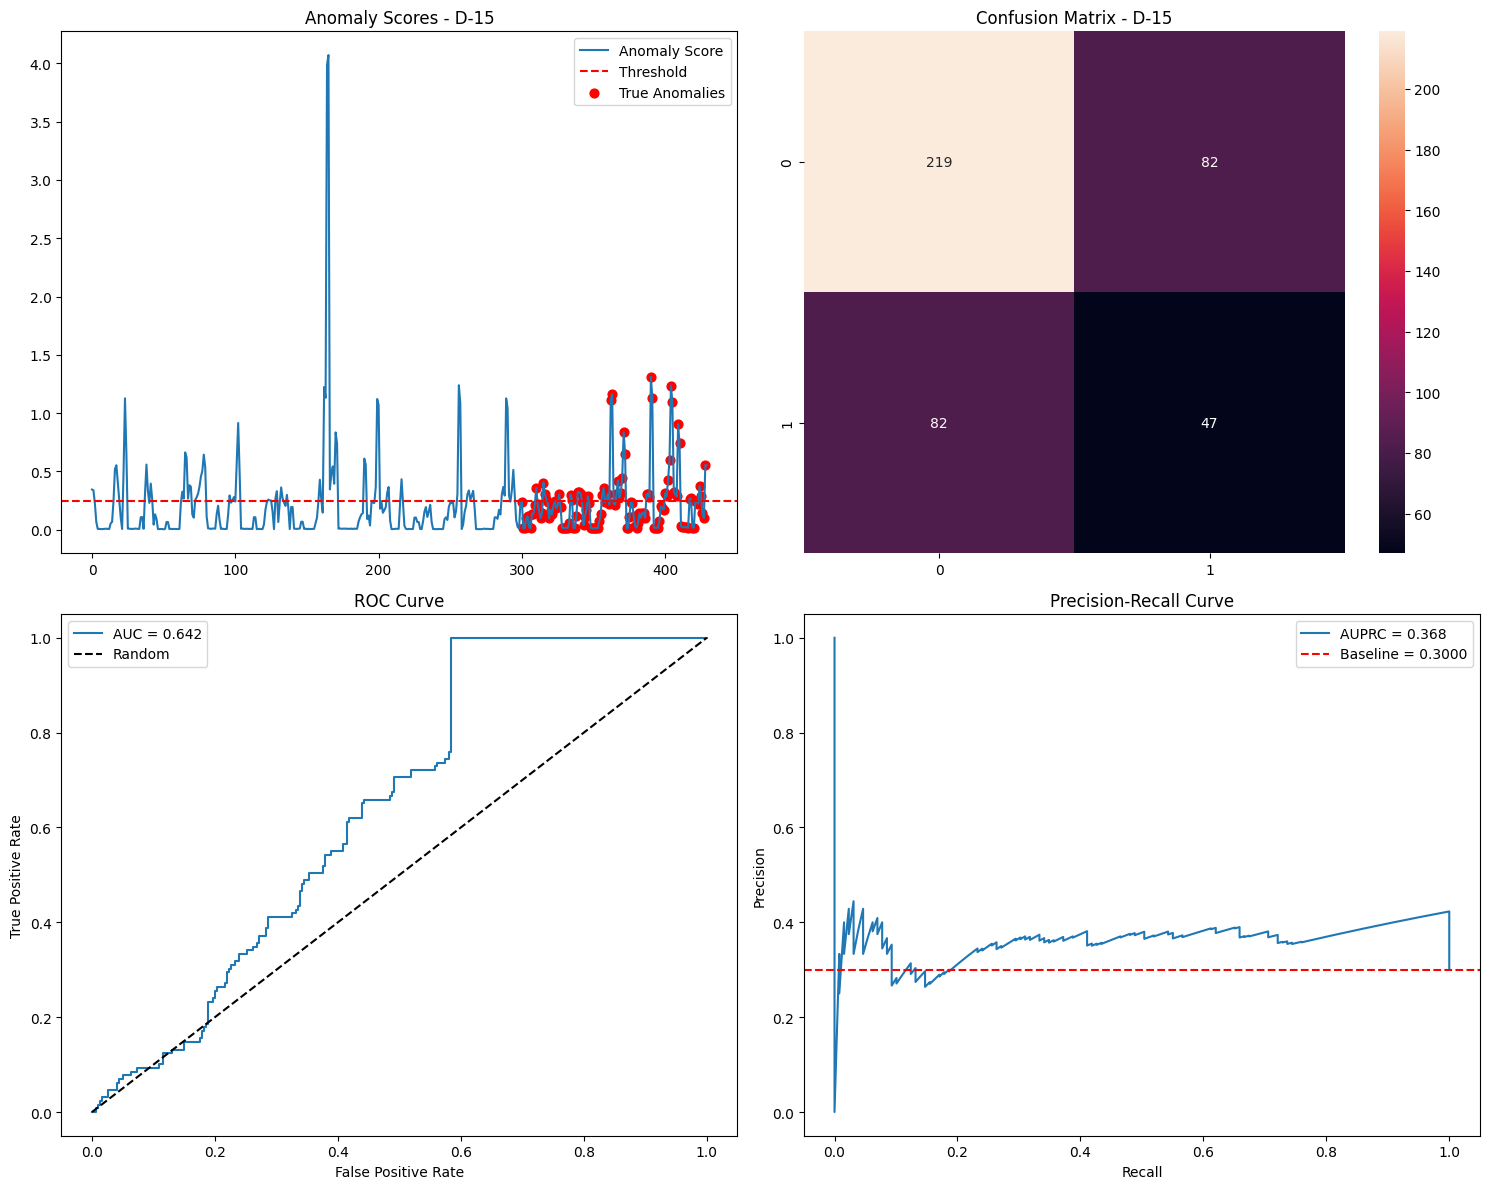


Metrics:
Accuracy: 0.619
Precision: 0.364
Recall: 0.364
F1: 0.364
AUROC: 0.642
AUPRC: 0.368 (Baseline: 0.3000)

Processing channel D-16
Channel D-16:
Total windows: 437
Anomaly windows: 131
Anomaly class: 79    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.4614, Val Loss: 0.3585
Epoch 2, Train Loss: 0.2918, Val Loss: 0.3107
Epoch 3, Train Loss: 0.2980, Val Loss: 0.2943
Epoch 4, Train Loss: 0.2603, Val Loss: 0.2862
Epoch 5, Train Loss: 0.2576, Val Loss: 0.2819
Epoch 6, Train Loss: 0.2568, Val Loss: 0.2797
Epoch 7, Train Loss: 0.3229, Val Loss: 0.2779
Epoch 8, Train Loss: 0.2506, Val Loss: 0.2772
Epoch 9, Train Loss: 0.2499, Val Loss: 0.2766
Epoch 10, Train Loss: 0.2527, Val Loss: 0.2762
Epoch 11, Train Loss: 0.3048, Val Loss: 0.2754
Epoch 12, Train Loss: 0.2511, Val Loss: 0.2754
Epoch 13, Train Loss: 0.2947, Val Loss: 0.2753
Epoch 14, Train Loss: 0.2767, Val Loss: 0.2748
Epoch 15, Train Loss: 0.2705, Val Loss: 0.2748
Epoch 16, Train Loss: 0.2491, Val Loss: 0.2744
Epoch

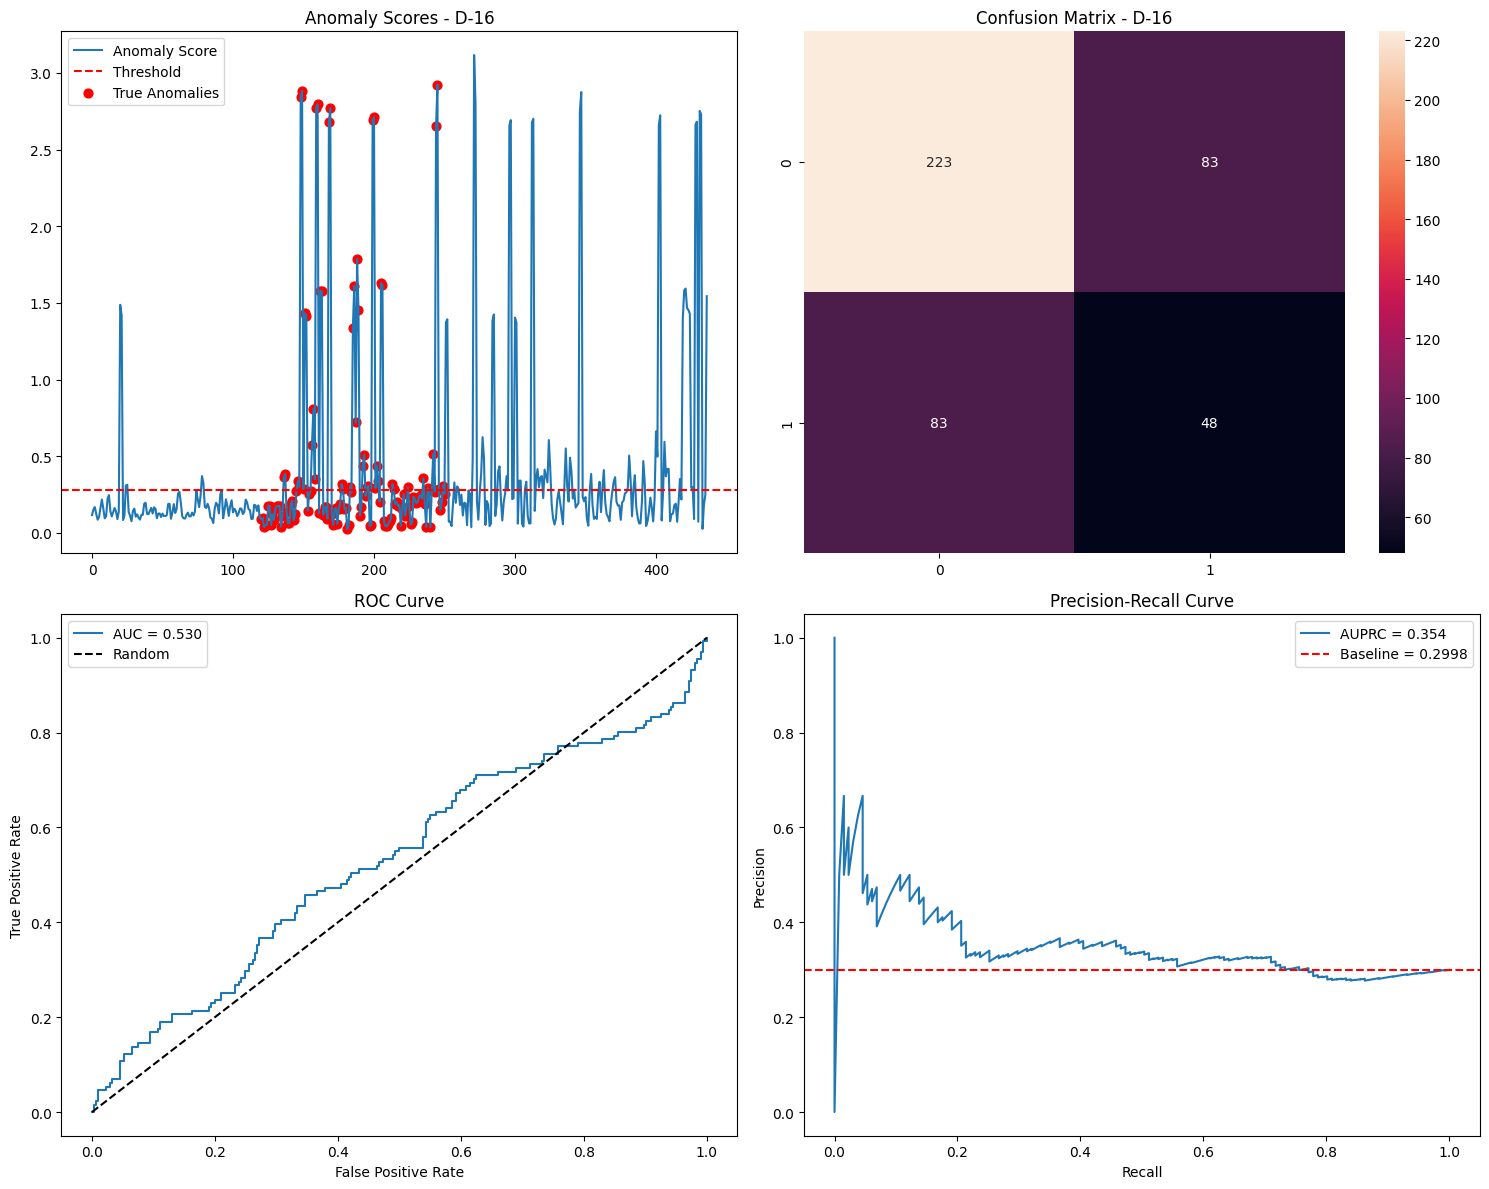


Metrics:
Accuracy: 0.620
Precision: 0.366
Recall: 0.366
F1: 0.366
AUROC: 0.530
AUPRC: 0.354 (Baseline: 0.2998)

Processing channel D-2
Channel D-2:
Total windows: 1718
Anomaly windows: 845
Anomaly class: 19    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.9248, Val Loss: 0.6984
Epoch 2, Train Loss: 0.7333, Val Loss: 0.6848
Epoch 3, Train Loss: 0.7620, Val Loss: 0.6779
Epoch 4, Train Loss: 0.7431, Val Loss: 0.6776
Epoch 5, Train Loss: 0.7750, Val Loss: 0.6760
Epoch 6, Train Loss: 0.7228, Val Loss: 0.6768
Epoch 7, Train Loss: 0.7425, Val Loss: 0.6775
Epoch 8, Train Loss: 0.7450, Val Loss: 0.6758
Epoch 9, Train Loss: 0.7372, Val Loss: 0.6765
Epoch 10, Train Loss: 0.8236, Val Loss: 0.6764
Epoch 11, Train Loss: 0.7180, Val Loss: 0.6754
Epoch 12, Train Loss: 0.7363, Val Loss: 0.6767
Epoch 13, Train Loss: 0.7808, Val Loss: 0.6748
Epoch 14, Train Loss: 0.7166, Val Loss: 0.6752
Epoch 15, Train Loss: 0.7965, Val Loss: 0.6766
Epoch 16, Train Loss: 0.7161, Val Loss: 0.6757
Epoch 17, T

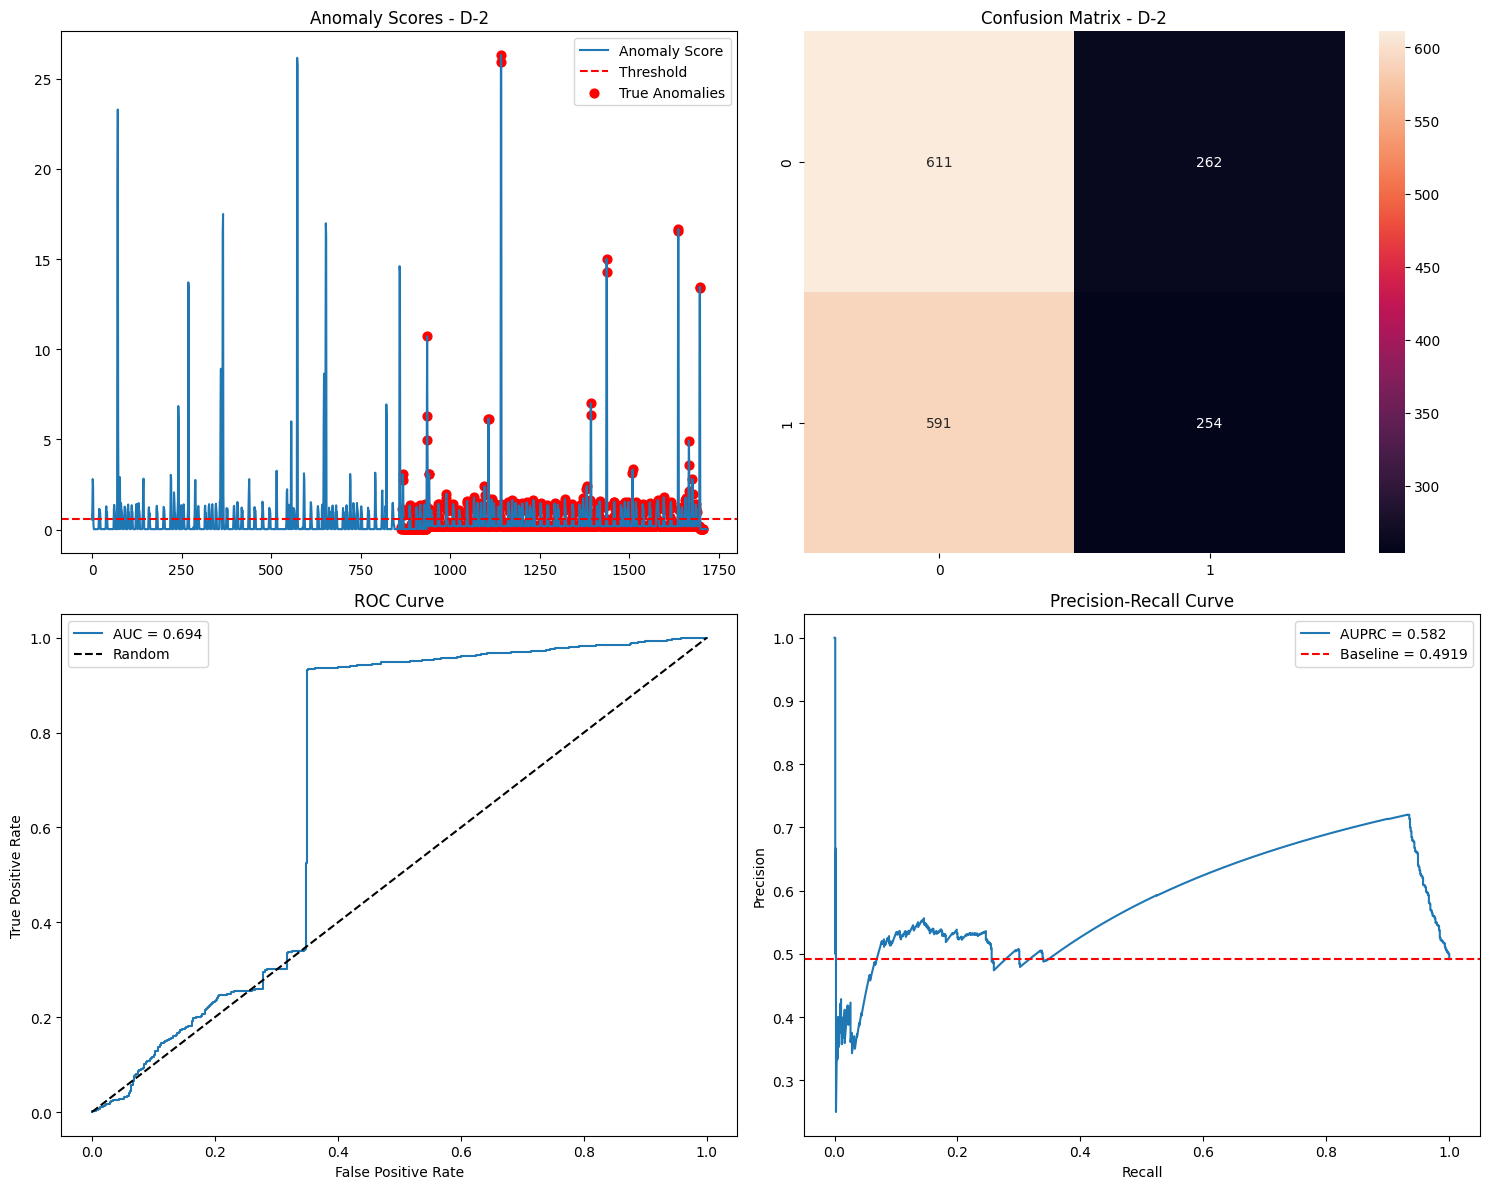


Metrics:
Accuracy: 0.503
Precision: 0.492
Recall: 0.301
F1: 0.373
AUROC: 0.694
AUPRC: 0.582 (Baseline: 0.4919)

Processing channel D-3
Channel D-3:
Total windows: 1727
Anomaly windows: 656
Anomaly class: 20    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.9328, Val Loss: 0.7350
Epoch 2, Train Loss: 0.8403, Val Loss: 0.7185
Epoch 3, Train Loss: 0.7588, Val Loss: 0.7160
Epoch 4, Train Loss: 0.7567, Val Loss: 0.7100
Epoch 5, Train Loss: 0.7602, Val Loss: 0.7116
Epoch 6, Train Loss: 0.7671, Val Loss: 0.7119
Epoch 7, Train Loss: 0.7471, Val Loss: 0.7114
Epoch 8, Train Loss: 0.7500, Val Loss: 0.7113
Epoch 9, Train Loss: 0.7436, Val Loss: 0.7121
Epoch 10, Train Loss: 0.7750, Val Loss: 0.7115
Epoch 11, Train Loss: 0.7557, Val Loss: 0.7129
Epoch 12, Train Loss: 0.7469, Val Loss: 0.7097
Epoch 13, Train Loss: 0.7472, Val Loss: 0.7117
Epoch 14, Train Loss: 0.7534, Val Loss: 0.7138
Epoch 15, Train Loss: 0.7611, Val Loss: 0.7130
Epoch 16, Train Loss: 0.7563, Val Loss: 0.7094
Epoch 17, T

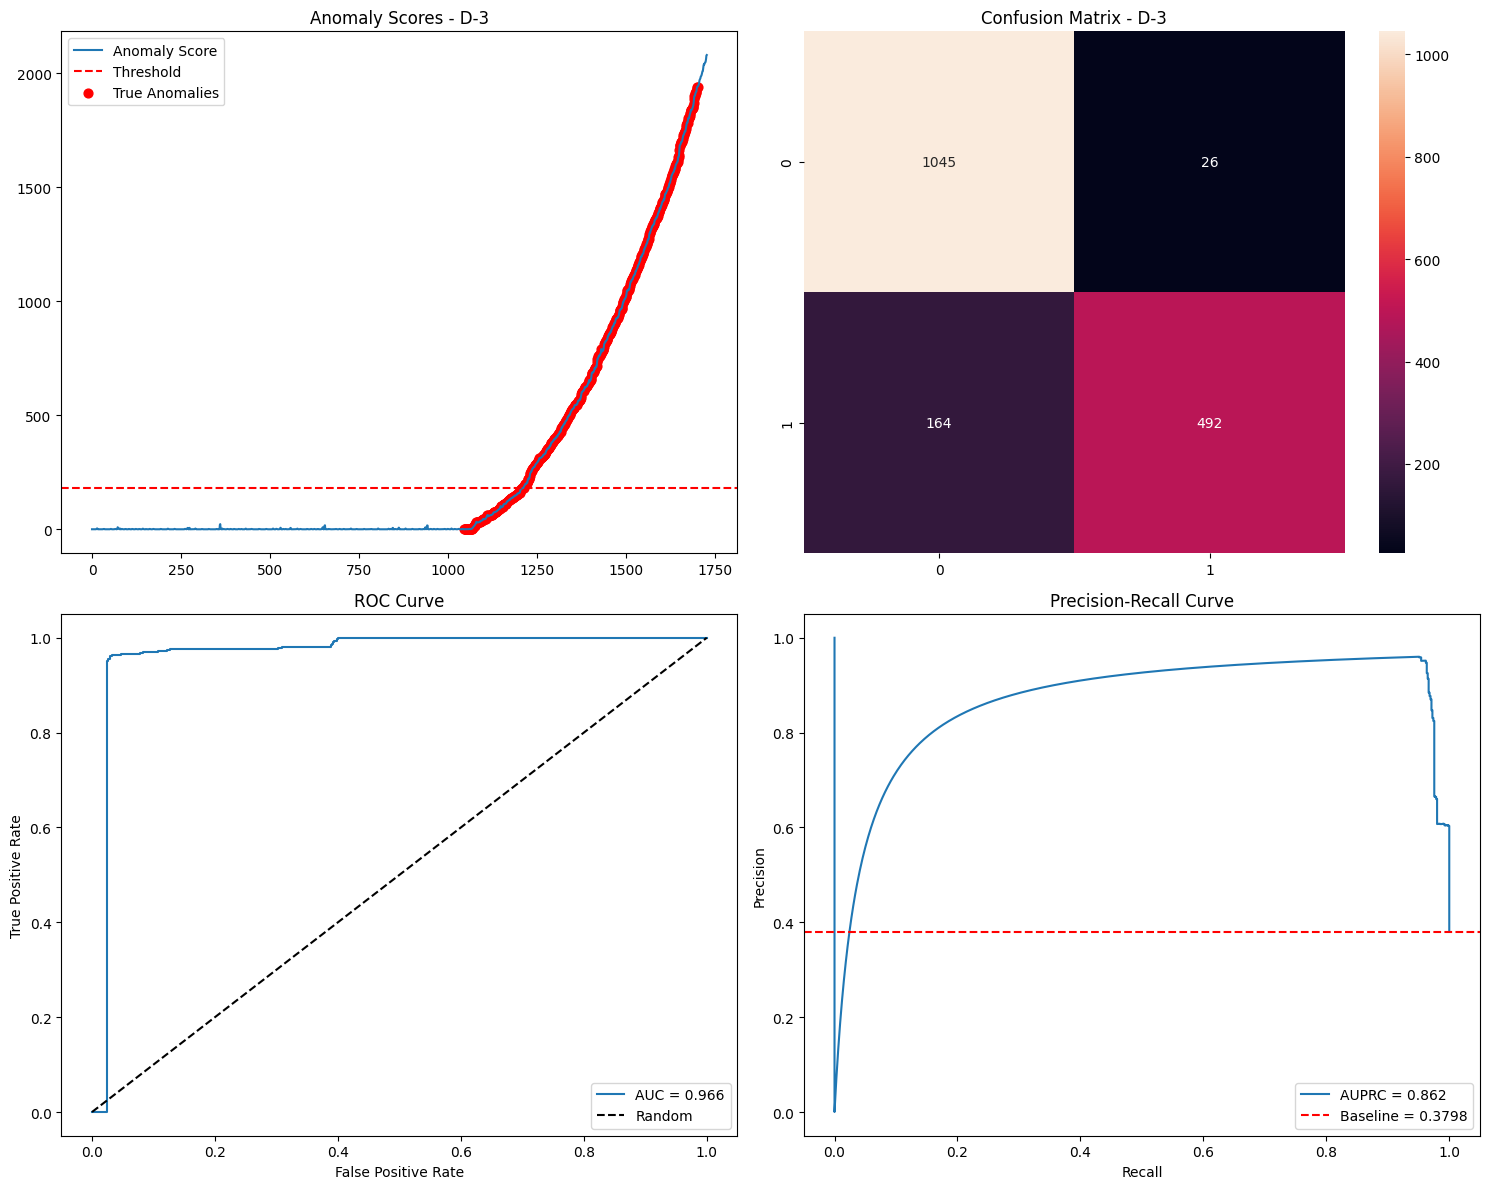


Metrics:
Accuracy: 0.890
Precision: 0.950
Recall: 0.750
F1: 0.838
AUROC: 0.966
AUPRC: 0.862 (Baseline: 0.3798)

Processing channel D-4
Channel D-4:
Total windows: 1693
Anomaly windows: 648
Anomaly class: 21    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8619, Val Loss: 0.7830
Epoch 2, Train Loss: 0.7257, Val Loss: 0.7685
Epoch 3, Train Loss: 0.7107, Val Loss: 0.7634
Epoch 4, Train Loss: 0.7271, Val Loss: 0.7593
Epoch 5, Train Loss: 0.7254, Val Loss: 0.7600
Epoch 6, Train Loss: 0.7087, Val Loss: 0.7555
Epoch 7, Train Loss: 0.7563, Val Loss: 0.7570
Epoch 8, Train Loss: 0.7051, Val Loss: 0.7587
Epoch 9, Train Loss: 0.7717, Val Loss: 0.7569
Epoch 10, Train Loss: 0.7061, Val Loss: 0.7574
Epoch 11, Train Loss: 0.8186, Val Loss: 0.7556
Epoch 12, Train Loss: 0.7343, Val Loss: 0.7567
Epoch 13, Train Loss: 0.7799, Val Loss: 0.7571
Epoch 14, Train Loss: 0.7103, Val Loss: 0.7574
Epoch 15, Train Loss: 0.7317, Val Loss: 0.7563
Epoch 16, Train Loss: 0.7548, Val Loss: 0.7574
Early stopp

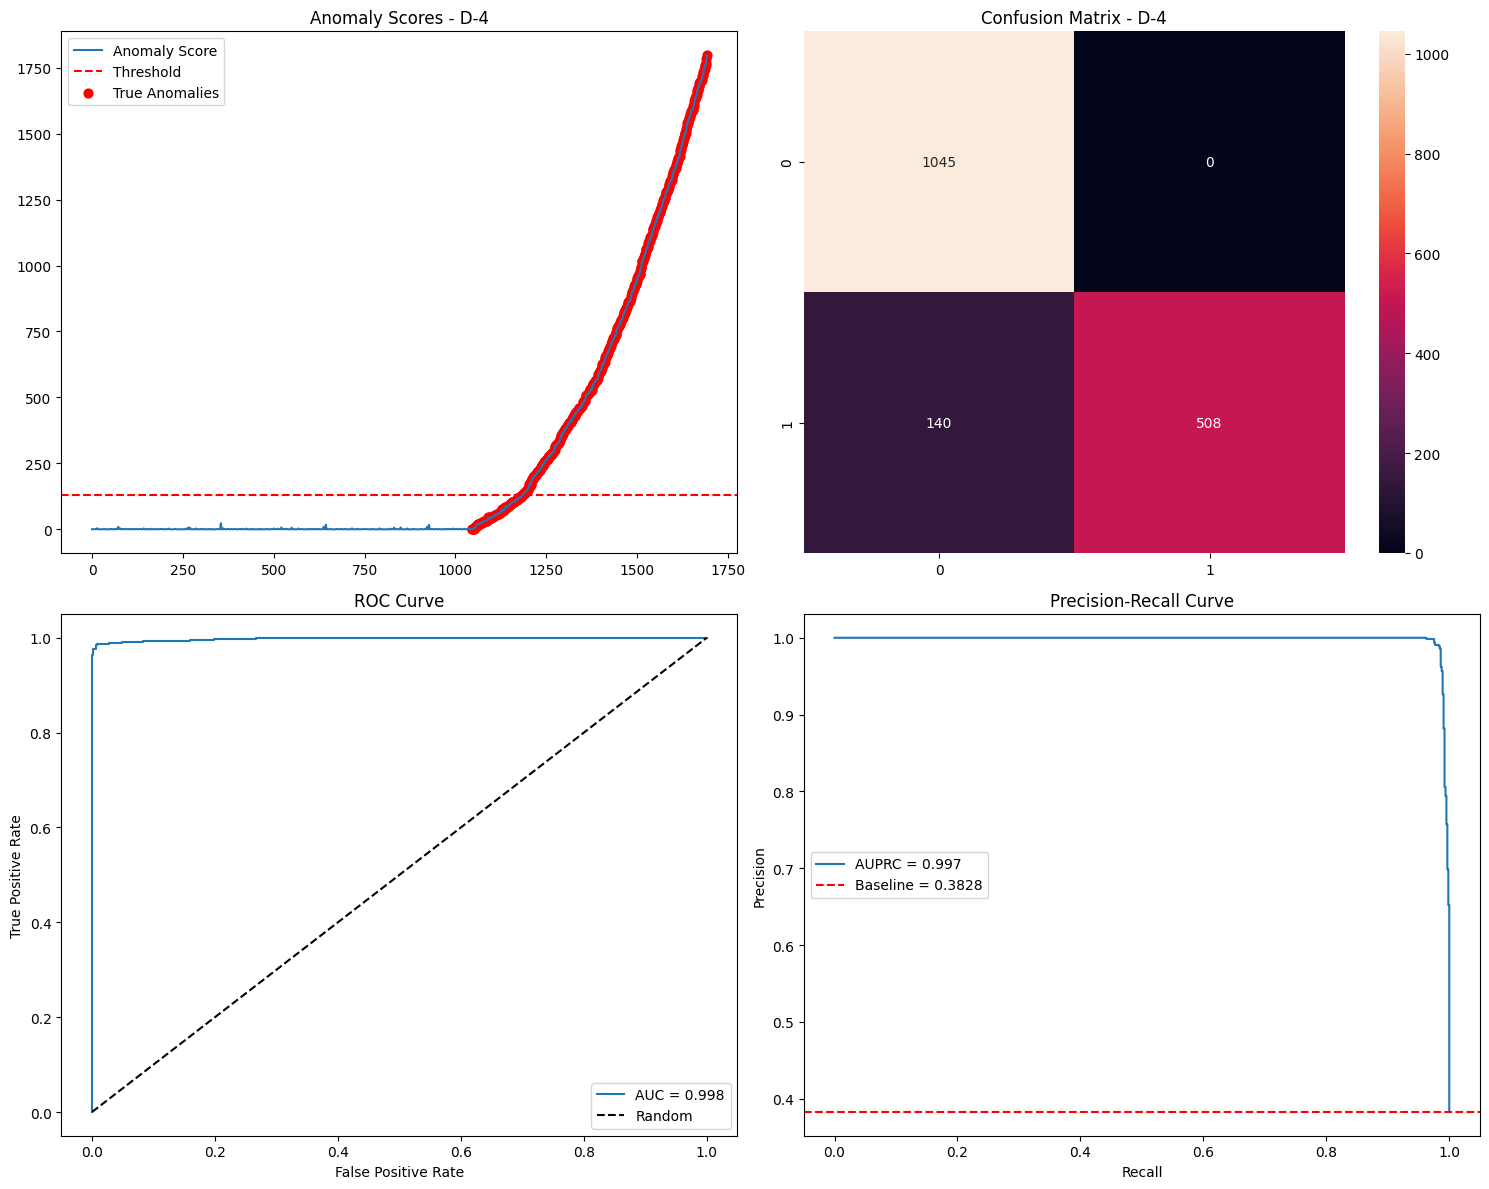


Metrics:
Accuracy: 0.917
Precision: 1.000
Recall: 0.784
F1: 0.879
AUROC: 0.998
AUPRC: 0.997 (Baseline: 0.3828)

Processing channel D-5
Channel D-5:
Total windows: 1524
Anomaly windows: 11
Anomaly class: 27    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-5
Found only 11 anomaly windows (minimum 100 required)

Processing channel D-6
Channel D-6:
Total windows: 1575
Anomaly windows: 17
Anomaly class: 28    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-6
Found only 17 anomaly windows (minimum 100 required)

Processing channel D-7
Channel D-7:
Total windows: 1527
Anomaly windows: 539
Anomaly class: 29    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8650, Val Loss: 0.4864
Epoch 2, Train Loss: 0.7875, Val Loss: 0.4780
Epoch 3, Train Loss: 0.7761, Val Loss: 0.4751
Epoch 4, Train Loss: 0.7840, Val Loss: 0.4730
Epoch 5, Train Loss: 0.7756, Val Loss: 0.4722
Epoch 6, Train Loss: 0.7724, Val Loss: 0.4737
Epoch 7, Train Loss: 0.7752, Val Loss:

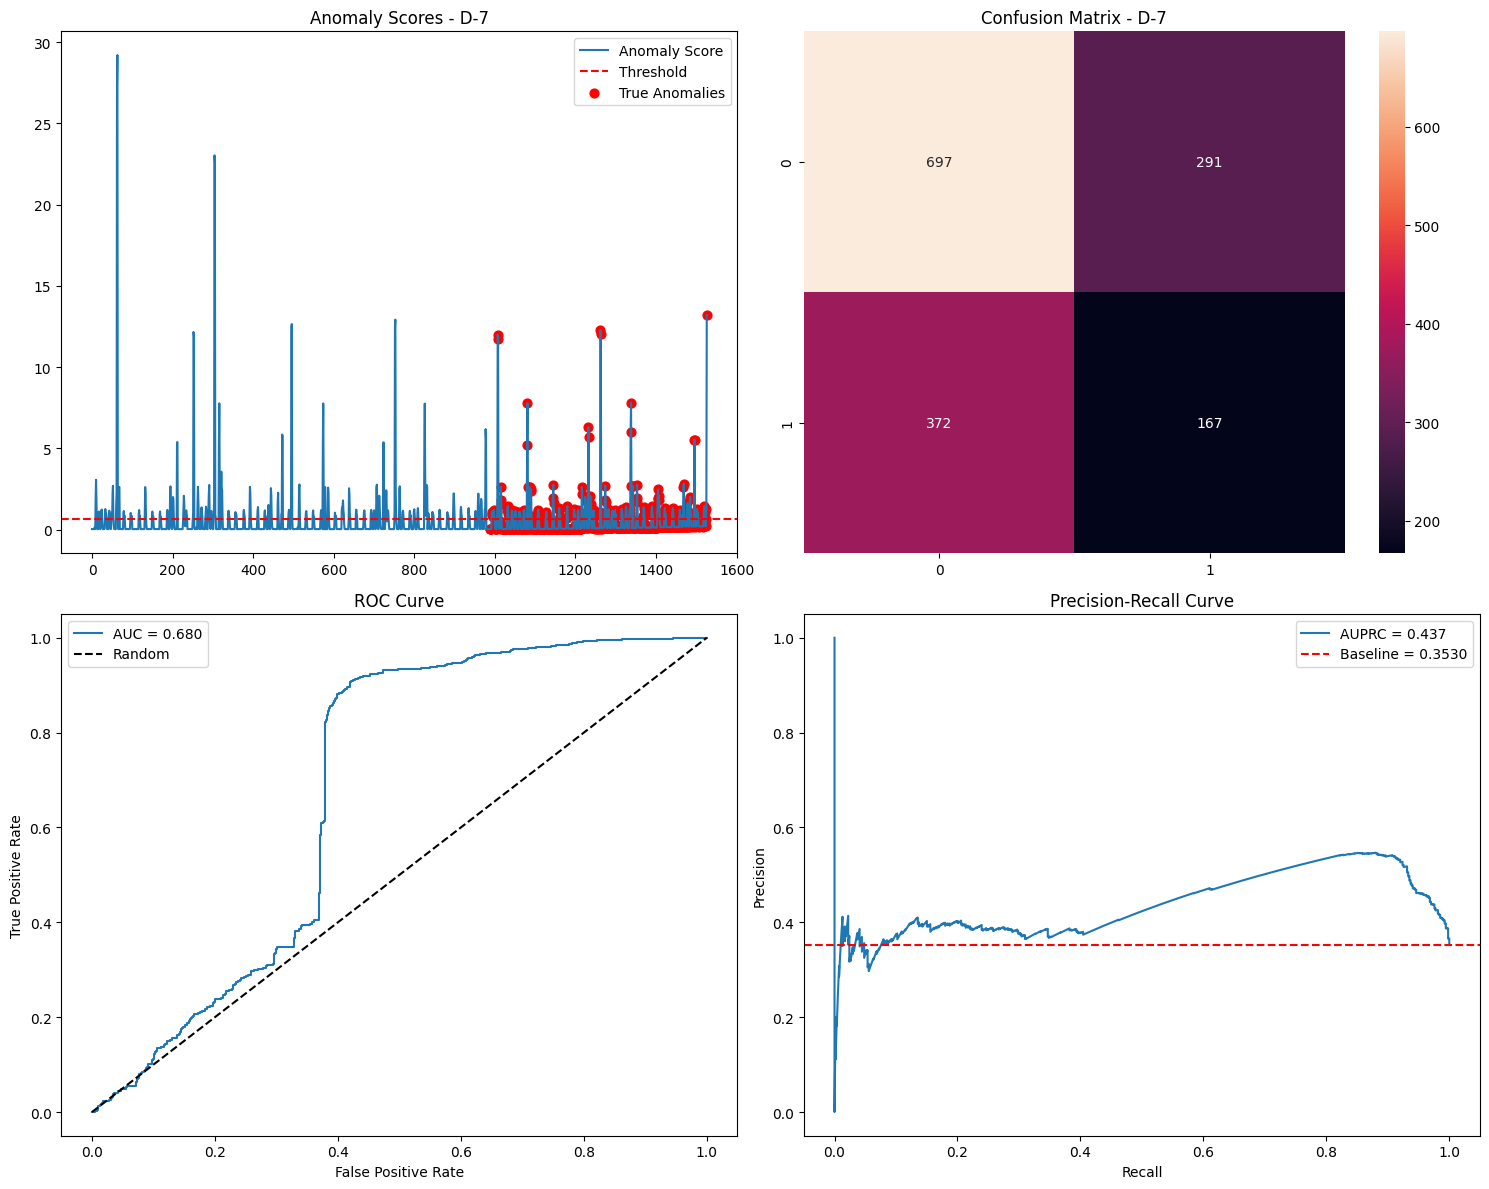


Metrics:
Accuracy: 0.566
Precision: 0.365
Recall: 0.310
F1: 0.335
AUROC: 0.680
AUPRC: 0.437 (Baseline: 0.3530)

Processing channel D-8
Channel D-8:
Total windows: 1573
Anomaly windows: 11
Anomaly class: 35    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-8
Found only 11 anomaly windows (minimum 100 required)

Processing channel D-9
Channel D-9:
Total windows: 1480
Anomaly windows: 230
Anomaly class: 36    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.5819, Val Loss: 0.7928
Epoch 2, Train Loss: 0.4904, Val Loss: 0.7759
Epoch 3, Train Loss: 0.4876, Val Loss: 0.7695
Epoch 4, Train Loss: 0.4845, Val Loss: 0.7696
Epoch 5, Train Loss: 0.4788, Val Loss: 0.7678
Epoch 6, Train Loss: 0.4928, Val Loss: 0.7670
Epoch 7, Train Loss: 0.4790, Val Loss: 0.7760
Epoch 8, Train Loss: 0.4851, Val Loss: 0.7699
Epoch 9, Train Loss: 0.4855, Val Loss: 0.7708
Epoch 10, Train Loss: 0.4822, Val Loss: 0.7690
Epoch 11, Train Loss: 0.4793, Val Loss: 0.7723
Epoch 12, Train Loss: 0.48

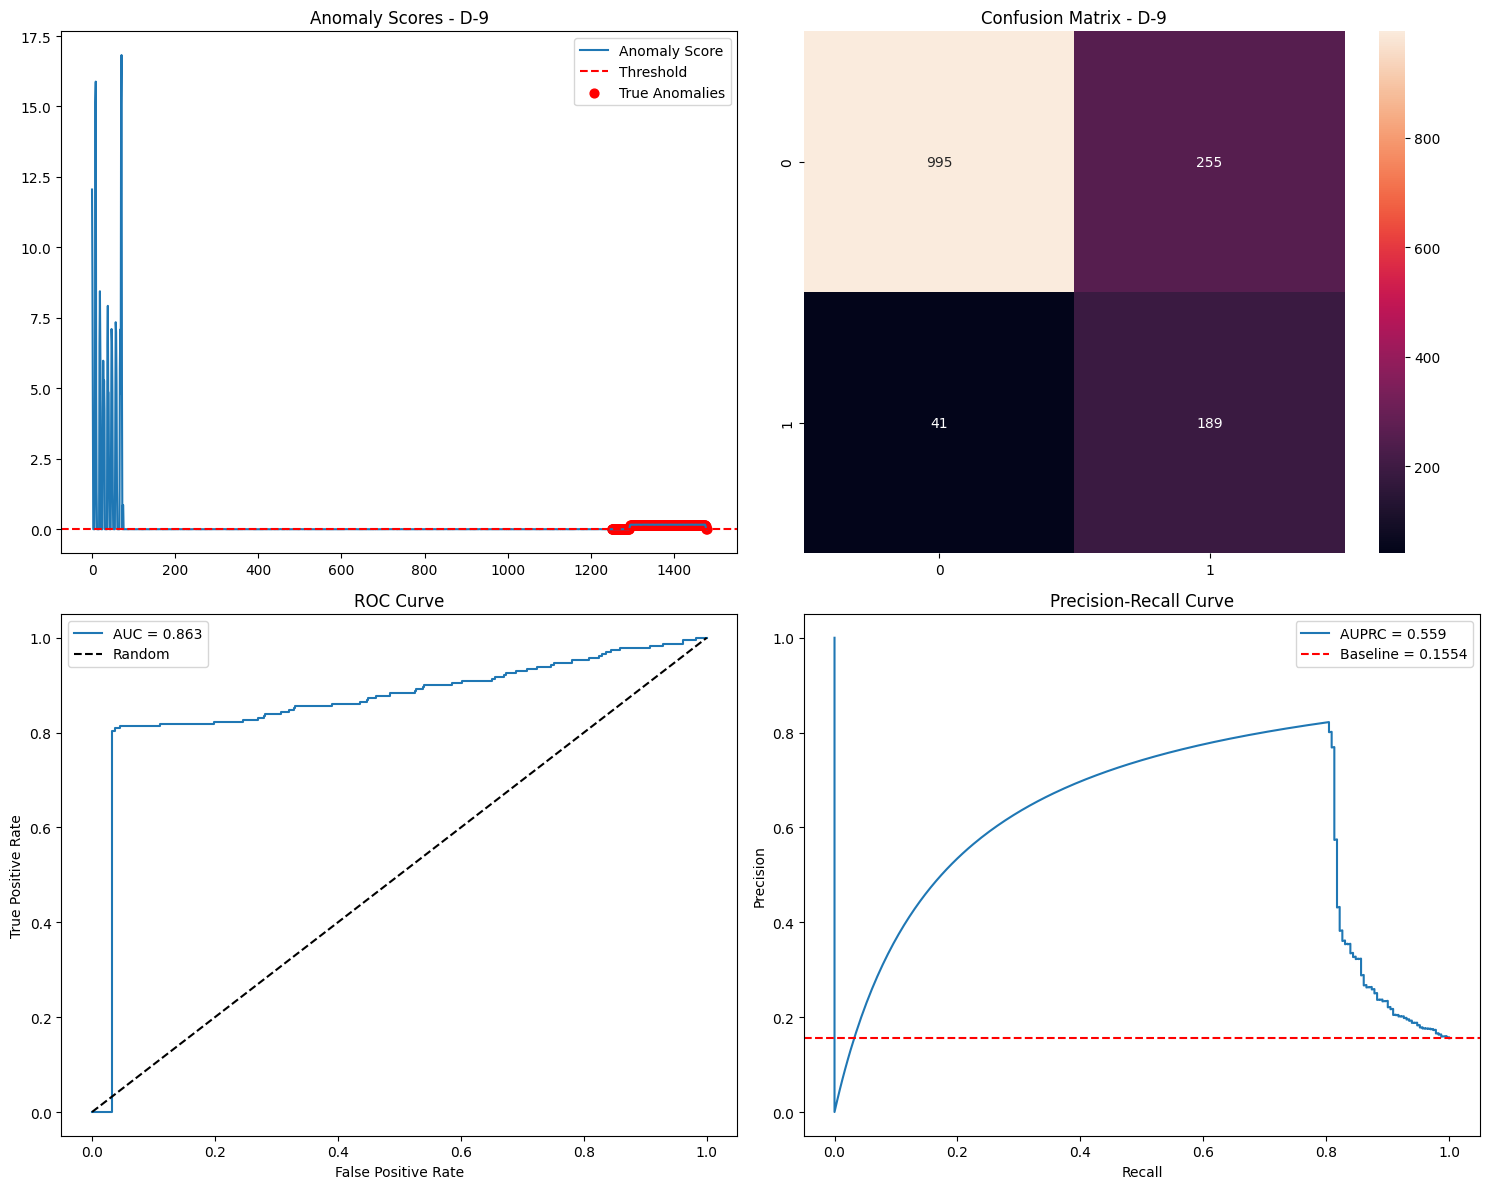


Metrics:
Accuracy: 0.800
Precision: 0.426
Recall: 0.822
F1: 0.561
AUROC: 0.863
AUPRC: 0.559 (Baseline: 0.1554)

Processing channel E-1
Channel E-1:
Total windows: 1702
Anomaly windows: 103
Anomaly class: 2    [contextual, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8315, Val Loss: 0.6485
Epoch 2, Train Loss: 0.7757, Val Loss: 0.6345
Epoch 3, Train Loss: 0.7429, Val Loss: 0.6312
Epoch 4, Train Loss: 0.7390, Val Loss: 0.6311
Epoch 5, Train Loss: 0.7263, Val Loss: 0.6295
Epoch 6, Train Loss: 0.7307, Val Loss: 0.6306
Epoch 7, Train Loss: 0.7262, Val Loss: 0.6272
Epoch 8, Train Loss: 0.7128, Val Loss: 0.6304
Epoch 9, Train Loss: 0.7411, Val Loss: 0.6287
Epoch 10, Train Loss: 0.7249, Val Loss: 0.6280
Epoch 11, Train Loss: 0.7185, Val Loss: 0.6279
Epoch 12, Train Loss: 0.7963, Val Loss: 0.6285
Epoch 13, Train Loss: 0.7220, Val Loss: 0.6273
Epoch 14, Train Loss: 0.7336, Val Loss: 0.6276
Epoch 15, Train Loss: 0.7161, Val Loss: 0.6272
Epoch 16, Train Loss: 0.7350, Val Loss: 0.

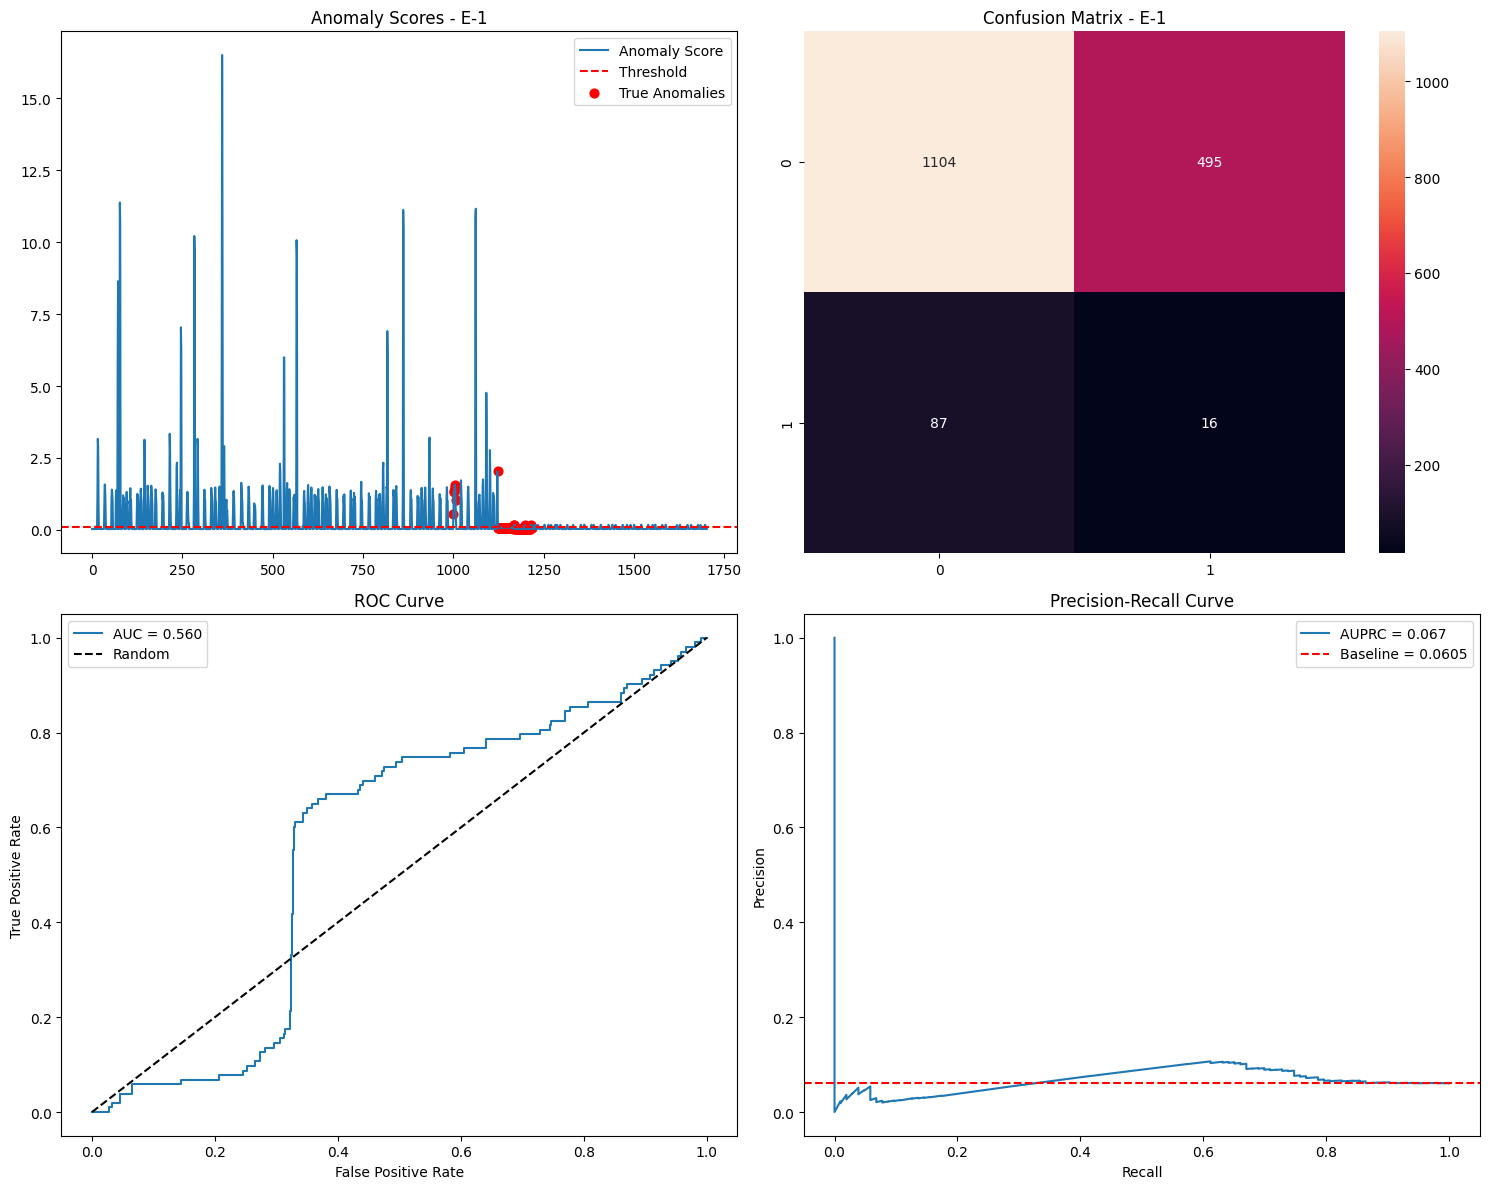


Metrics:
Accuracy: 0.658
Precision: 0.031
Recall: 0.155
F1: 0.052
AUROC: 0.560
AUPRC: 0.067 (Baseline: 0.0605)

Processing channel E-10
Channel E-10:
Total windows: 1700
Anomaly windows: 66
Anomaly class: 11    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-10
Found only 66 anomaly windows (minimum 100 required)

Processing channel E-11
Channel E-11:
Total windows: 1701
Anomaly windows: 61
Anomaly class: 12    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-11
Found only 61 anomaly windows (minimum 100 required)

Processing channel E-12
Channel E-12:
Total windows: 1701
Anomaly windows: 118
Anomaly class: 13    [contextual, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7773, Val Loss: 0.9048
Epoch 2, Train Loss: 0.6995, Val Loss: 0.8894
Epoch 3, Train Loss: 0.7241, Val Loss: 0.8862
Epoch 4, Train Loss: 0.6700, Val Loss: 0.8900
Epoch 5, Train Loss: 0.6778, Val Loss: 0.8880
Epoch 6, Train Loss: 0.69

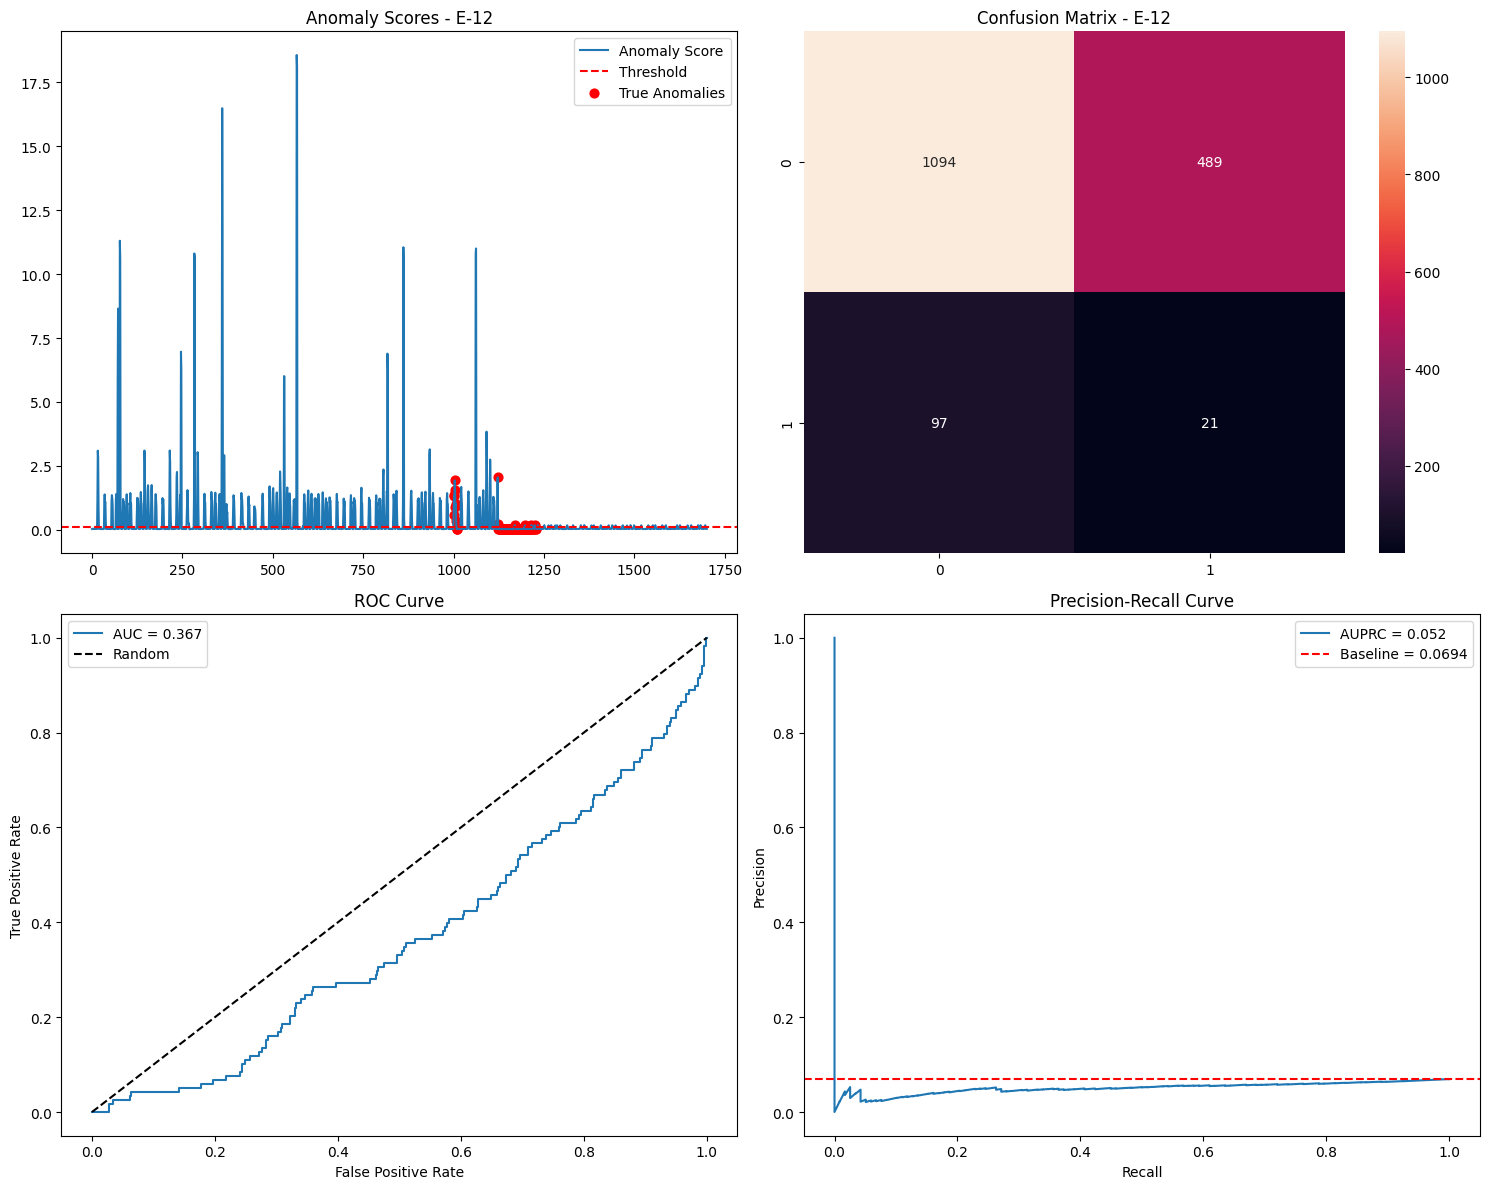


Metrics:
Accuracy: 0.655
Precision: 0.041
Recall: 0.178
F1: 0.067
AUROC: 0.367
AUPRC: 0.052 (Baseline: 0.0694)

Processing channel E-13
Channel E-13:
Total windows: 1727
Anomaly windows: 56
Anomaly class: 14    [contextual, contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-13
Found only 56 anomaly windows (minimum 100 required)

Processing channel E-2
Channel E-2:
Total windows: 1705
Anomaly windows: 281
Anomaly class: 3    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8631, Val Loss: 0.5590
Epoch 2, Train Loss: 0.7819, Val Loss: 0.5493
Epoch 3, Train Loss: 0.7514, Val Loss: 0.5456
Epoch 4, Train Loss: 0.7579, Val Loss: 0.5444
Epoch 5, Train Loss: 0.8095, Val Loss: 0.5443
Epoch 6, Train Loss: 0.7460, Val Loss: 0.5429
Epoch 7, Train Loss: 0.7915, Val Loss: 0.5423
Epoch 8, Train Loss: 0.7521, Val Loss: 0.5433
Epoch 9, Train Loss: 0.7968, Val Loss: 0.5445
Epoch 10, Train Loss: 0.7432, Val Loss: 0.5450
Epoch 11, Train Loss: 0.7759, Val Loss: 0.

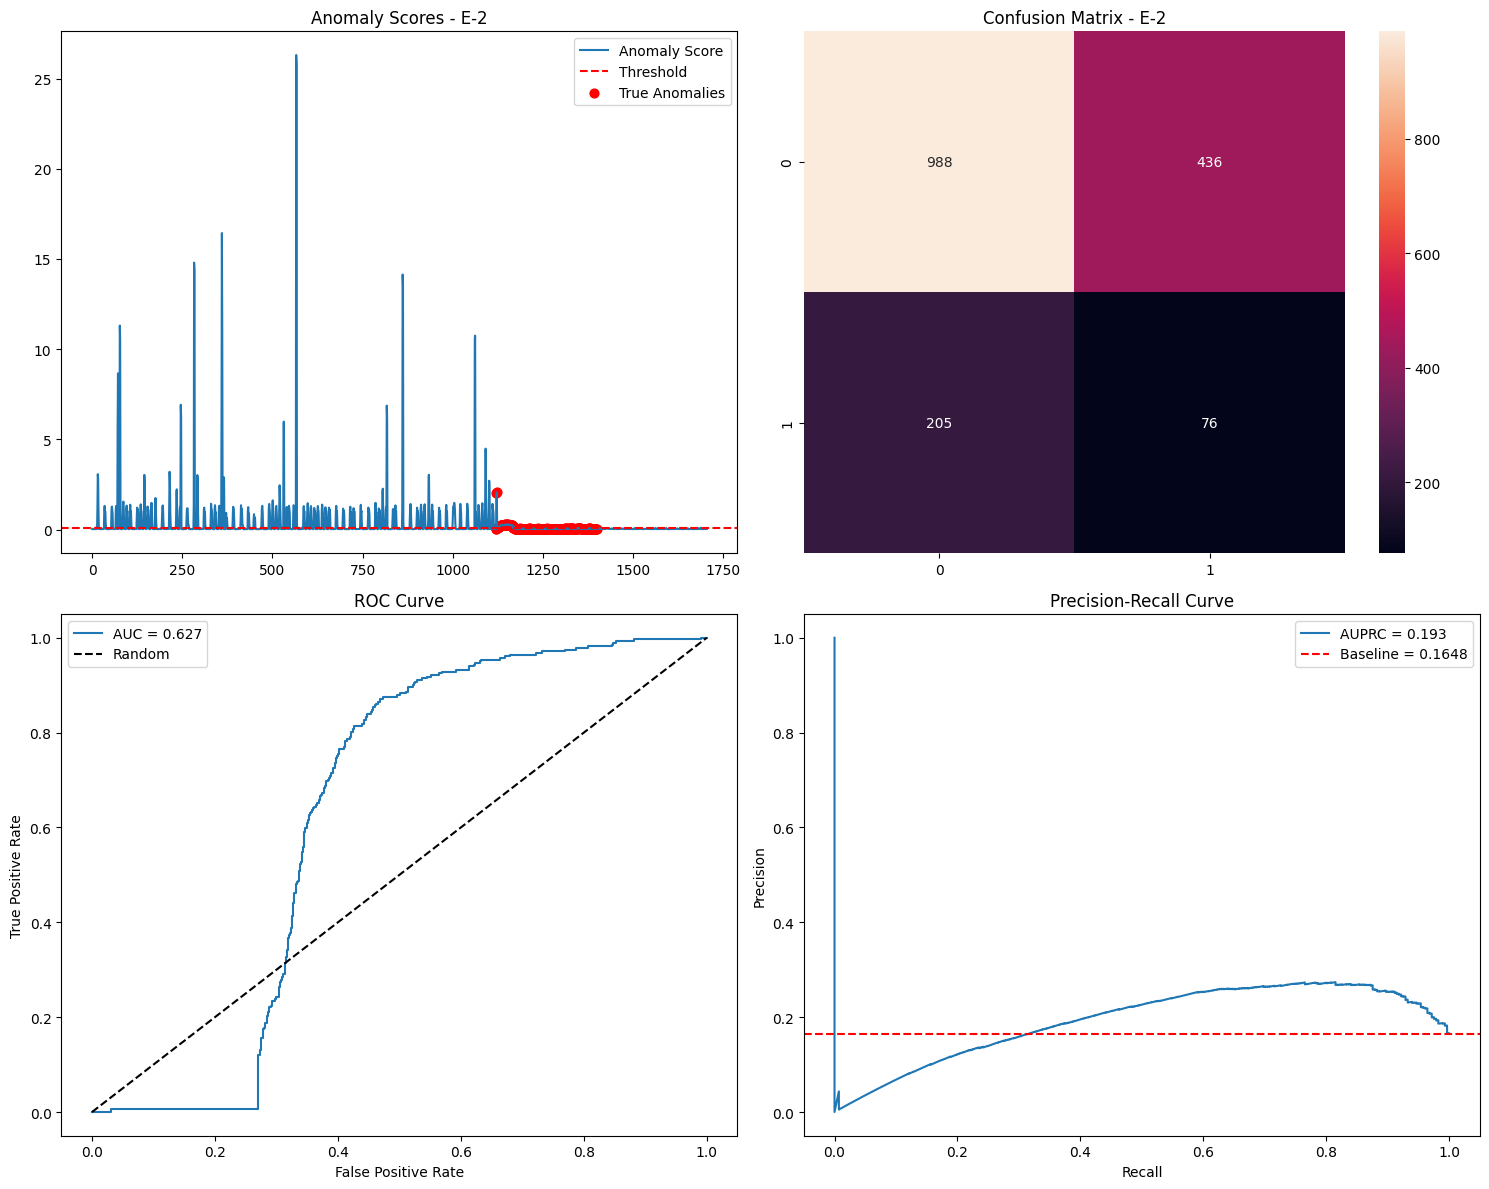


Metrics:
Accuracy: 0.624
Precision: 0.148
Recall: 0.270
F1: 0.192
AUROC: 0.627
AUPRC: 0.193 (Baseline: 0.1648)

Processing channel E-3
Channel E-3:
Total windows: 1660
Anomaly windows: 642
Anomaly class: 4    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8376, Val Loss: 0.6237
Epoch 2, Train Loss: 0.7428, Val Loss: 0.6032
Epoch 3, Train Loss: 0.7421, Val Loss: 0.5948
Epoch 4, Train Loss: 0.7404, Val Loss: 0.5949
Epoch 5, Train Loss: 0.7358, Val Loss: 0.5929
Epoch 6, Train Loss: 0.7732, Val Loss: 0.5909
Epoch 7, Train Loss: 0.7267, Val Loss: 0.5922
Epoch 8, Train Loss: 0.7404, Val Loss: 0.5900
Epoch 9, Train Loss: 0.7204, Val Loss: 0.5908
Epoch 10, Train Loss: 0.7513, Val Loss: 0.5911
Epoch 11, Train Loss: 0.7358, Val Loss: 0.5907
Epoch 12, Train Loss: 0.7212, Val Loss: 0.5910
Epoch 13, Train Loss: 0.7292, Val Loss: 0.5915
Epoch 14, Train Loss: 0.7296, Val Loss: 0.5912
Epoch 15, Train Loss: 0.7791, Val Loss: 0.5906
Epoch 16, Train Loss: 0.7320, Val Loss: 0.5917
Epoch 17, Tr

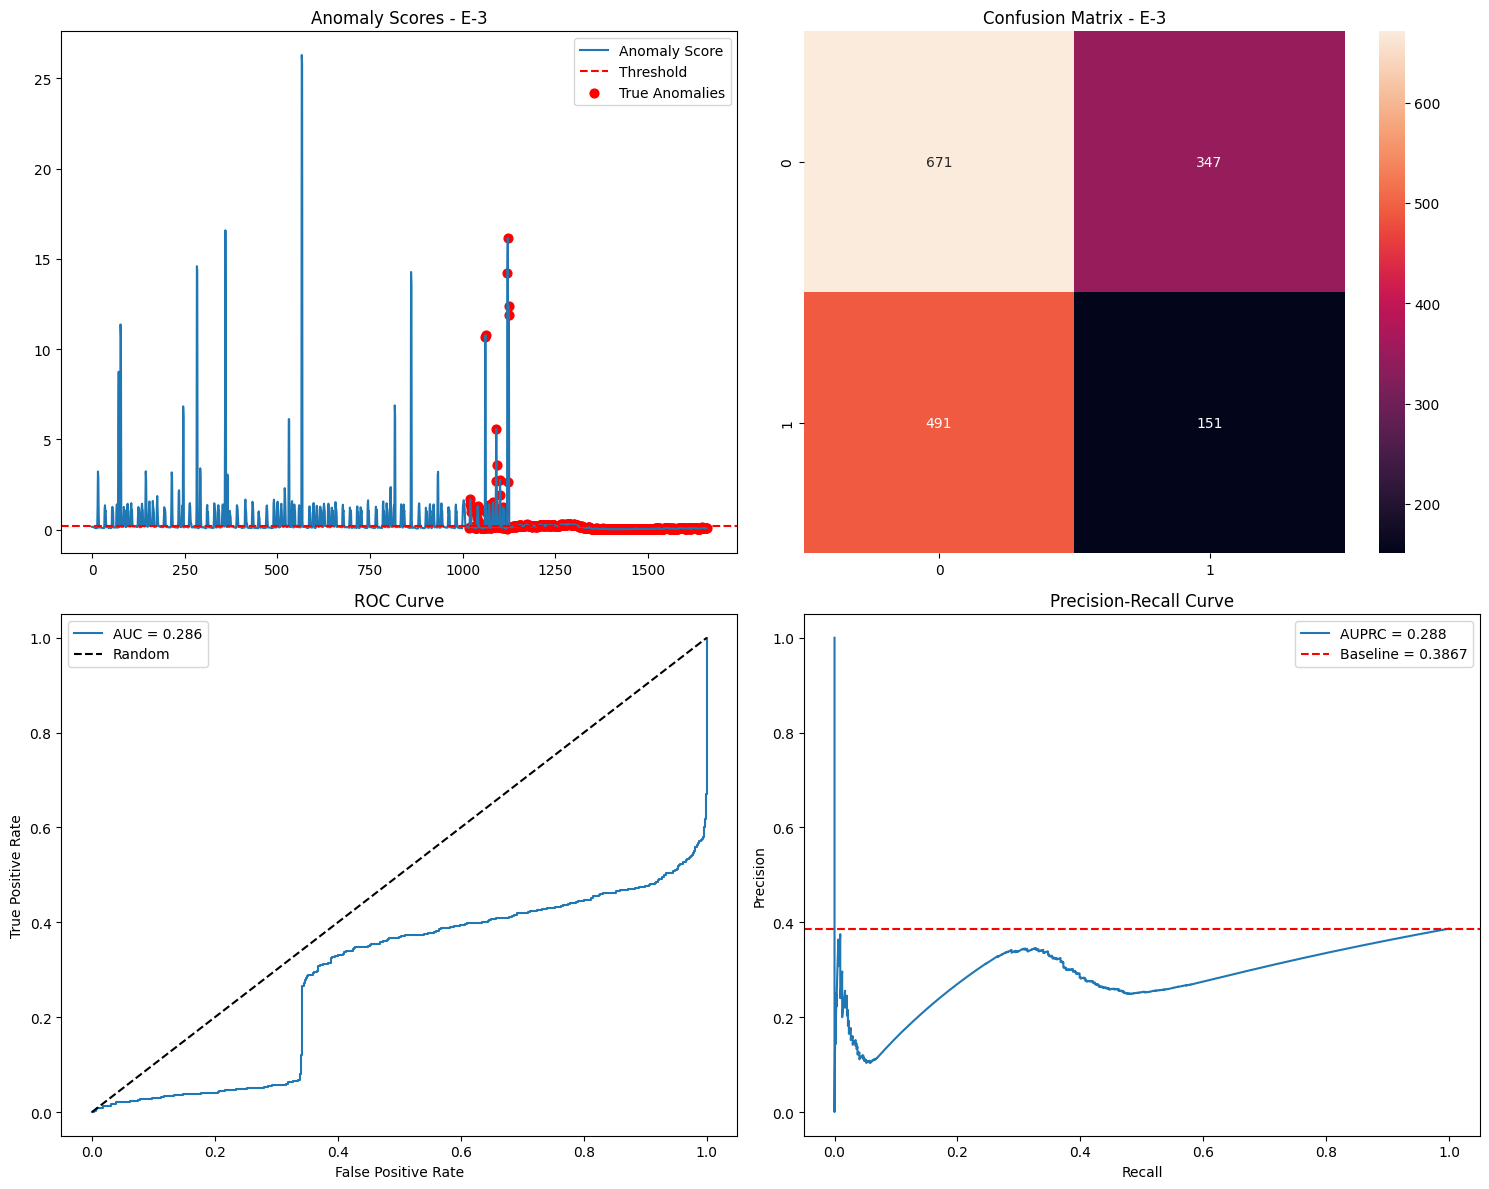


Metrics:
Accuracy: 0.495
Precision: 0.303
Recall: 0.235
F1: 0.265
AUROC: 0.286
AUPRC: 0.288 (Baseline: 0.3867)

Processing channel E-4
Channel E-4:
Total windows: 1669
Anomaly windows: 563
Anomaly class: 5    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7750, Val Loss: 1.0325
Epoch 2, Train Loss: 0.6782, Val Loss: 1.0188
Epoch 3, Train Loss: 0.6518, Val Loss: 1.0118
Epoch 4, Train Loss: 0.6852, Val Loss: 1.0099
Epoch 5, Train Loss: 0.6723, Val Loss: 1.0094
Epoch 6, Train Loss: 0.6906, Val Loss: 1.0082
Epoch 7, Train Loss: 0.6505, Val Loss: 1.0077
Epoch 8, Train Loss: 0.6581, Val Loss: 1.0073
Epoch 9, Train Loss: 0.6552, Val Loss: 1.0084
Epoch 10, Train Loss: 0.7101, Val Loss: 1.0082
Epoch 11, Train Loss: 0.6493, Val Loss: 1.0088
Epoch 12, Train Loss: 0.6366, Val Loss: 1.0078
Epoch 13, Train Loss: 0.7267, Val Loss: 1.0078
Epoch 14, Train Loss: 0.6552, Val Loss: 1.0066
Epoch 15, Train Loss: 0.6433, Val Loss: 1.0072
Epoch 16, Train Loss: 0.6783, Val Loss: 1.0079
Epoch 17, Tr

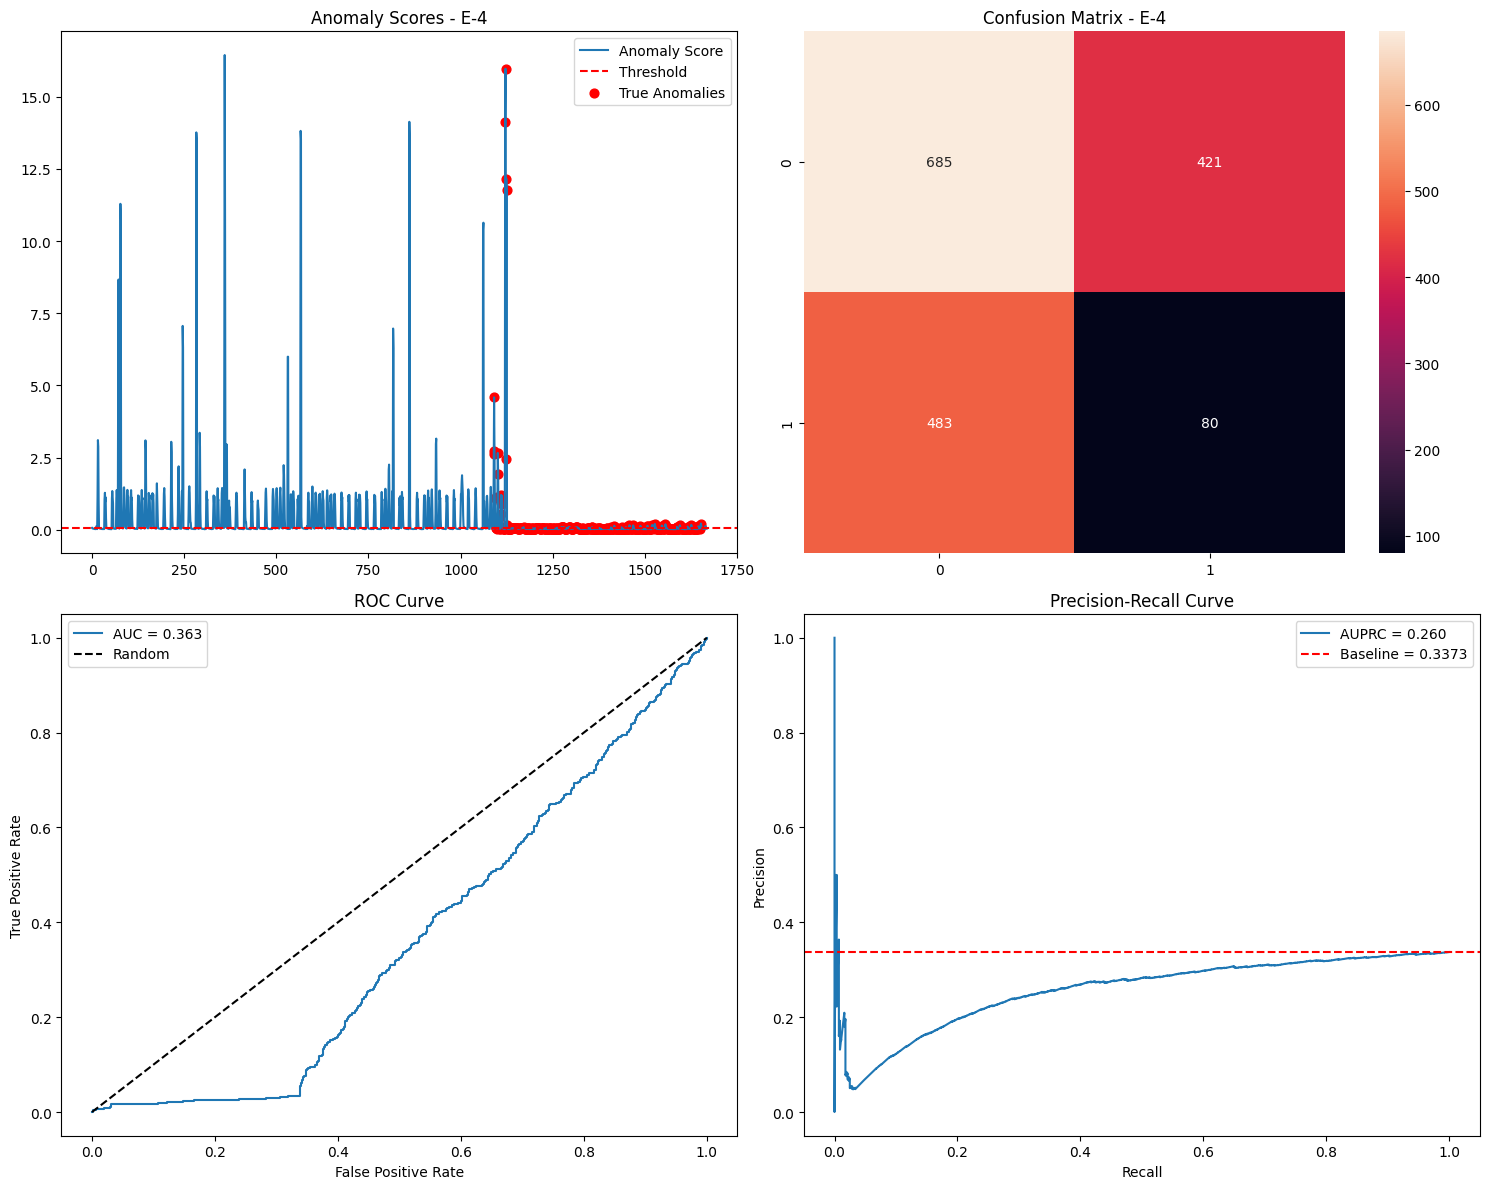


Metrics:
Accuracy: 0.458
Precision: 0.160
Recall: 0.142
F1: 0.150
AUROC: 0.363
AUPRC: 0.260 (Baseline: 0.3373)

Processing channel E-5
Channel E-5:
Total windows: 1657
Anomaly windows: 65
Anomaly class: 6    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-5
Found only 65 anomaly windows (minimum 100 required)

Processing channel E-6
Channel E-6:
Total windows: 1659
Anomaly windows: 14
Anomaly class: 7    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-6
Found only 14 anomaly windows (minimum 100 required)

Processing channel E-7
Channel E-7:
Total windows: 1661
Anomaly windows: 57
Anomaly class: 8    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-7
Found only 57 anomaly windows (minimum 100 required)

Processing channel E-8
Channel E-8:
Total windows: 1705
Anomaly windows: 125
Anomaly class: 9    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.9006, Val Loss: 0.5064
Epoch 2, Train Loss: 0.8138, Val Loss: 0.4871
Epoch 

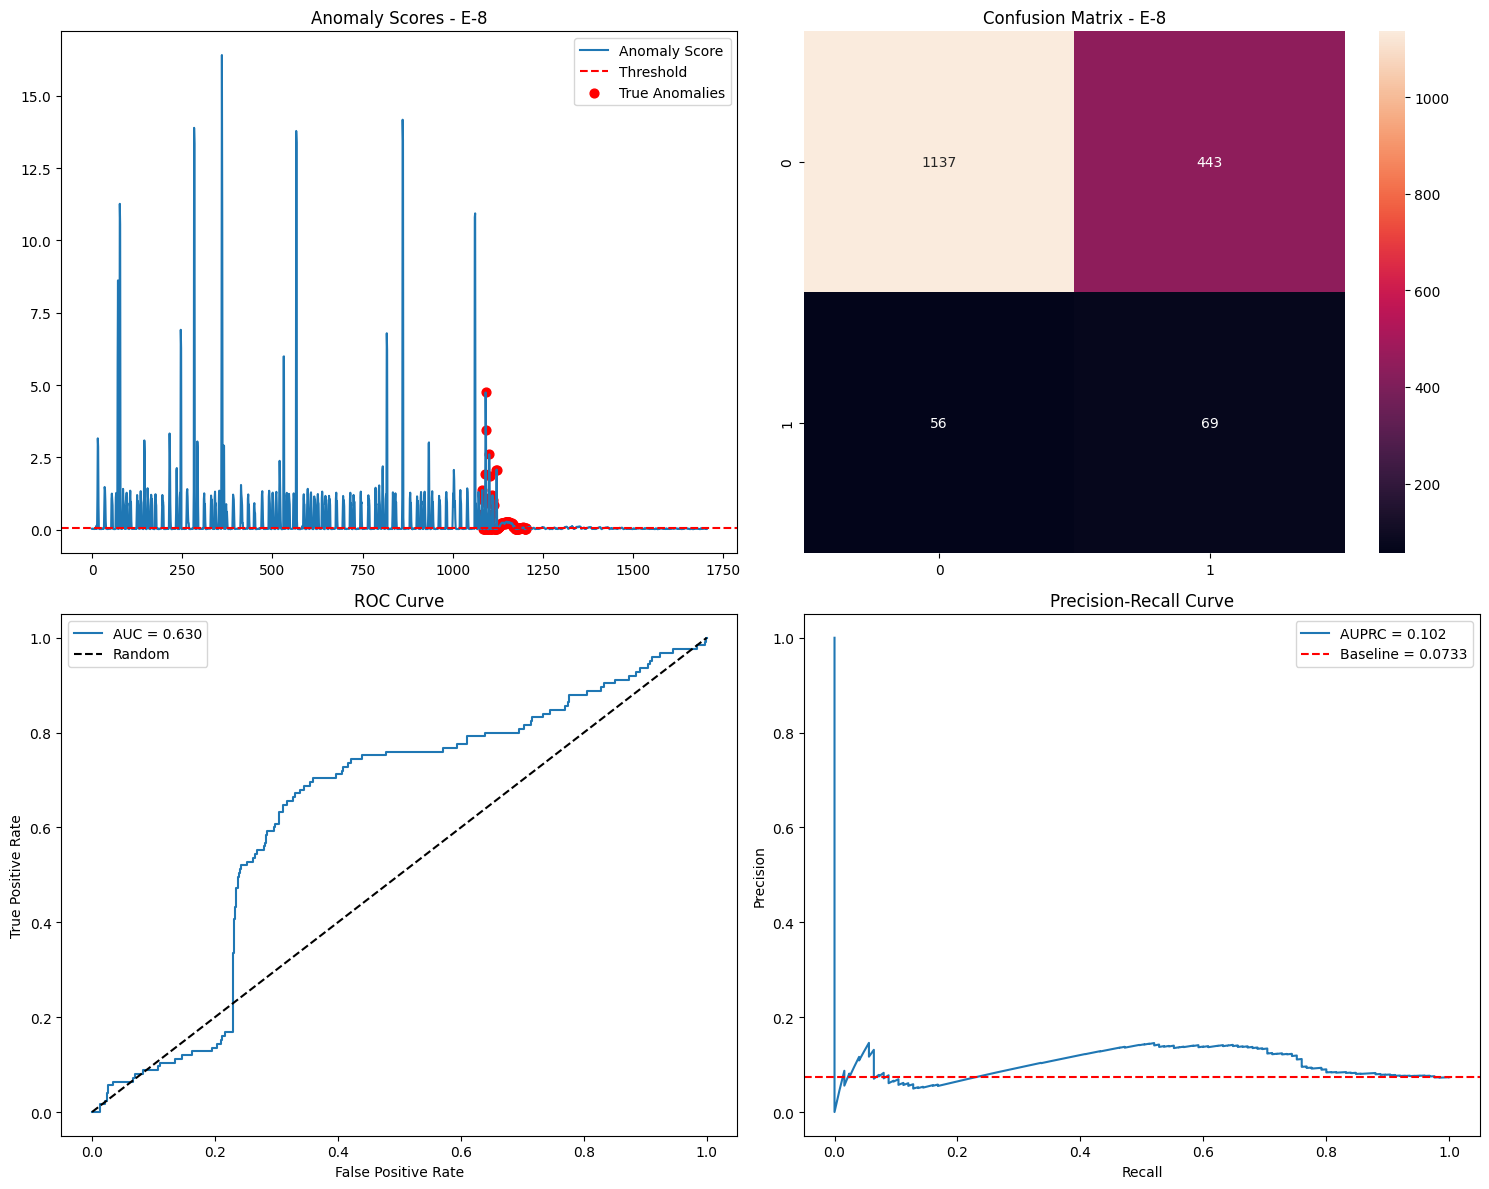


Metrics:
Accuracy: 0.707
Precision: 0.135
Recall: 0.552
F1: 0.217
AUROC: 0.630
AUPRC: 0.102 (Baseline: 0.0733)

Processing channel E-9
Channel E-9:
Total windows: 1659
Anomaly windows: 71
Anomaly class: 10    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-9
Found only 71 anomaly windows (minimum 100 required)

Processing channel F-1
Channel F-1:
Total windows: 1715
Anomaly windows: 21
Anomaly class: 30    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-1
Found only 21 anomaly windows (minimum 100 required)

Processing channel F-2
Channel F-2:
Total windows: 1724
Anomaly windows: 591
Anomaly class: 37    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.6584, Val Loss: 0.5457
Epoch 2, Train Loss: 0.5691, Val Loss: 0.5332
Epoch 3, Train Loss: 0.5836, Val Loss: 0.5335
Epoch 4, Train Loss: 0.5716, Val Loss: 0.5317
Epoch 5, Train Loss: 0.5529, Val Loss: 0.5324
Epoch 6, Train Loss: 0.5897, Val Loss: 0.5304
Epoch 7, Train Loss: 0.5528, Val Loss:

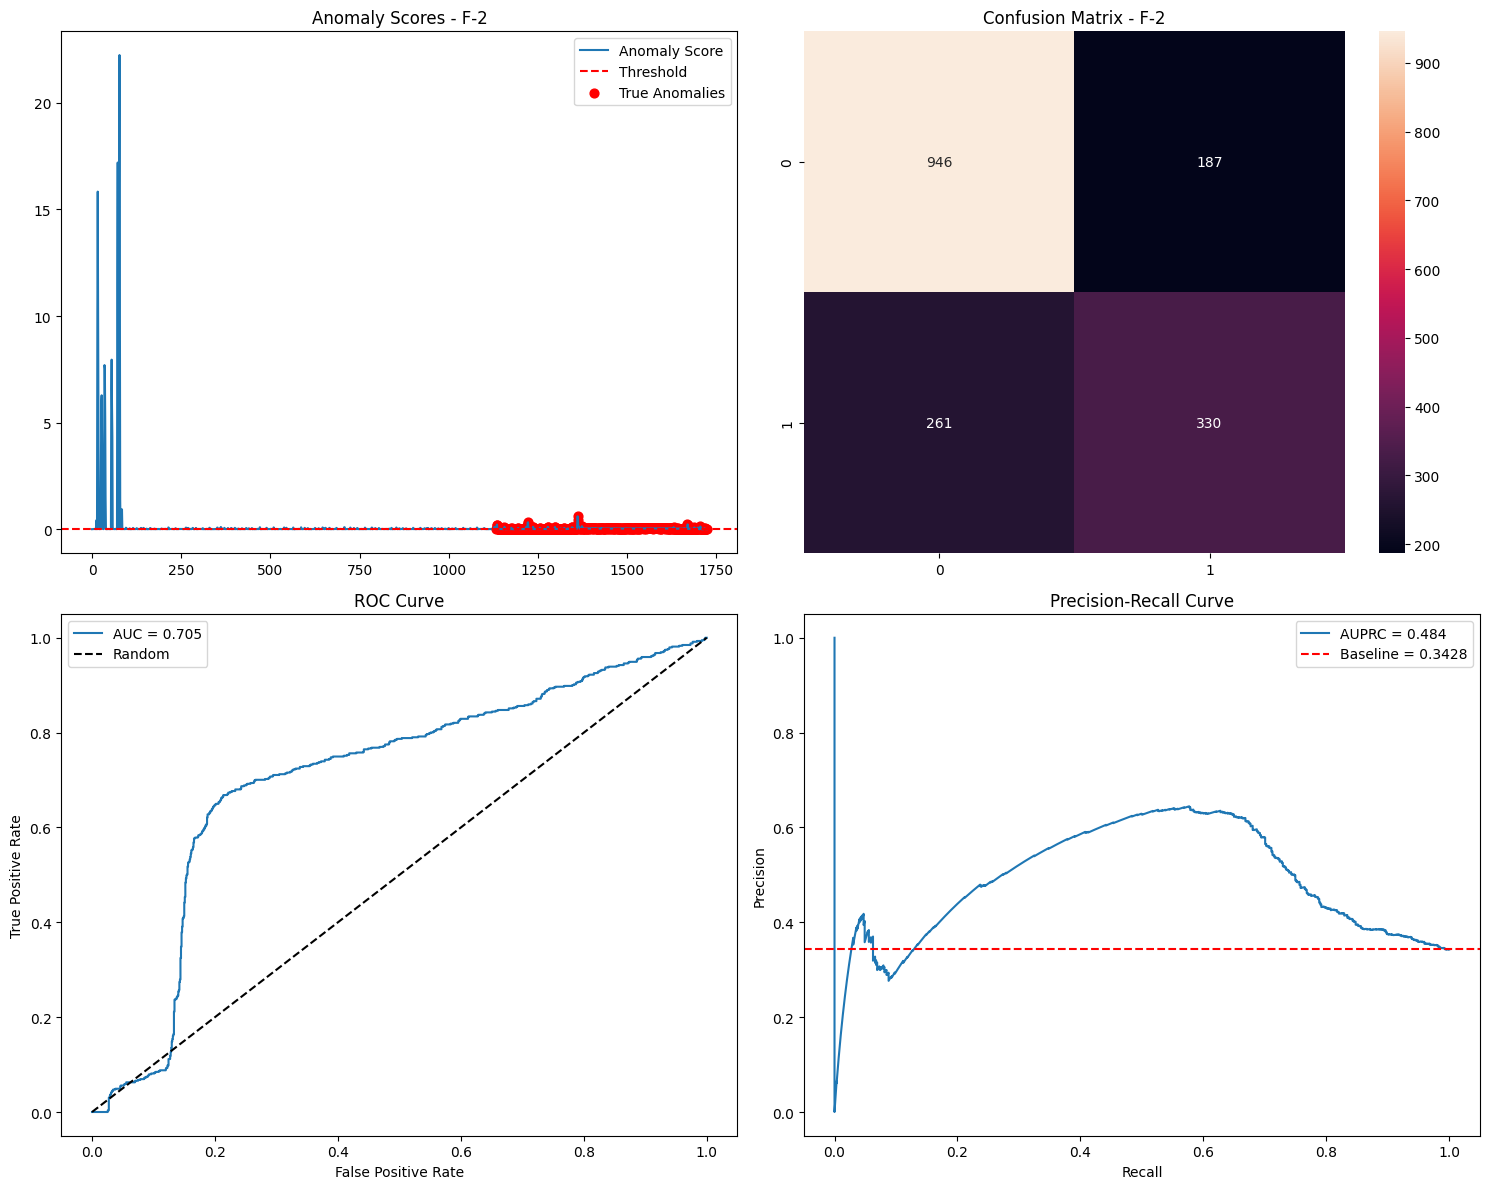


Metrics:
Accuracy: 0.740
Precision: 0.638
Recall: 0.558
F1: 0.596
AUROC: 0.705
AUPRC: 0.484 (Baseline: 0.3428)

Processing channel F-3
Channel F-3:
Total windows: 1674
Anomaly windows: 9
Anomaly class: 54    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-3
Found only 9 anomaly windows (minimum 100 required)

Processing channel F-4
Channel F-4:
Total windows: 683
Anomaly windows: 15
Anomaly class: 71    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-4
Found only 15 anomaly windows (minimum 100 required)

Processing channel F-5
Channel F-5:
Total windows: 783
Anomaly windows: 31
Anomaly class: 72    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-5
Found only 31 anomaly windows (minimum 100 required)

Processing channel F-7
Channel F-7:
Total windows: 1009
Anomaly windows: 87
Anomaly class: 62    [contextual, contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-7
Found only 87 anomaly windows (

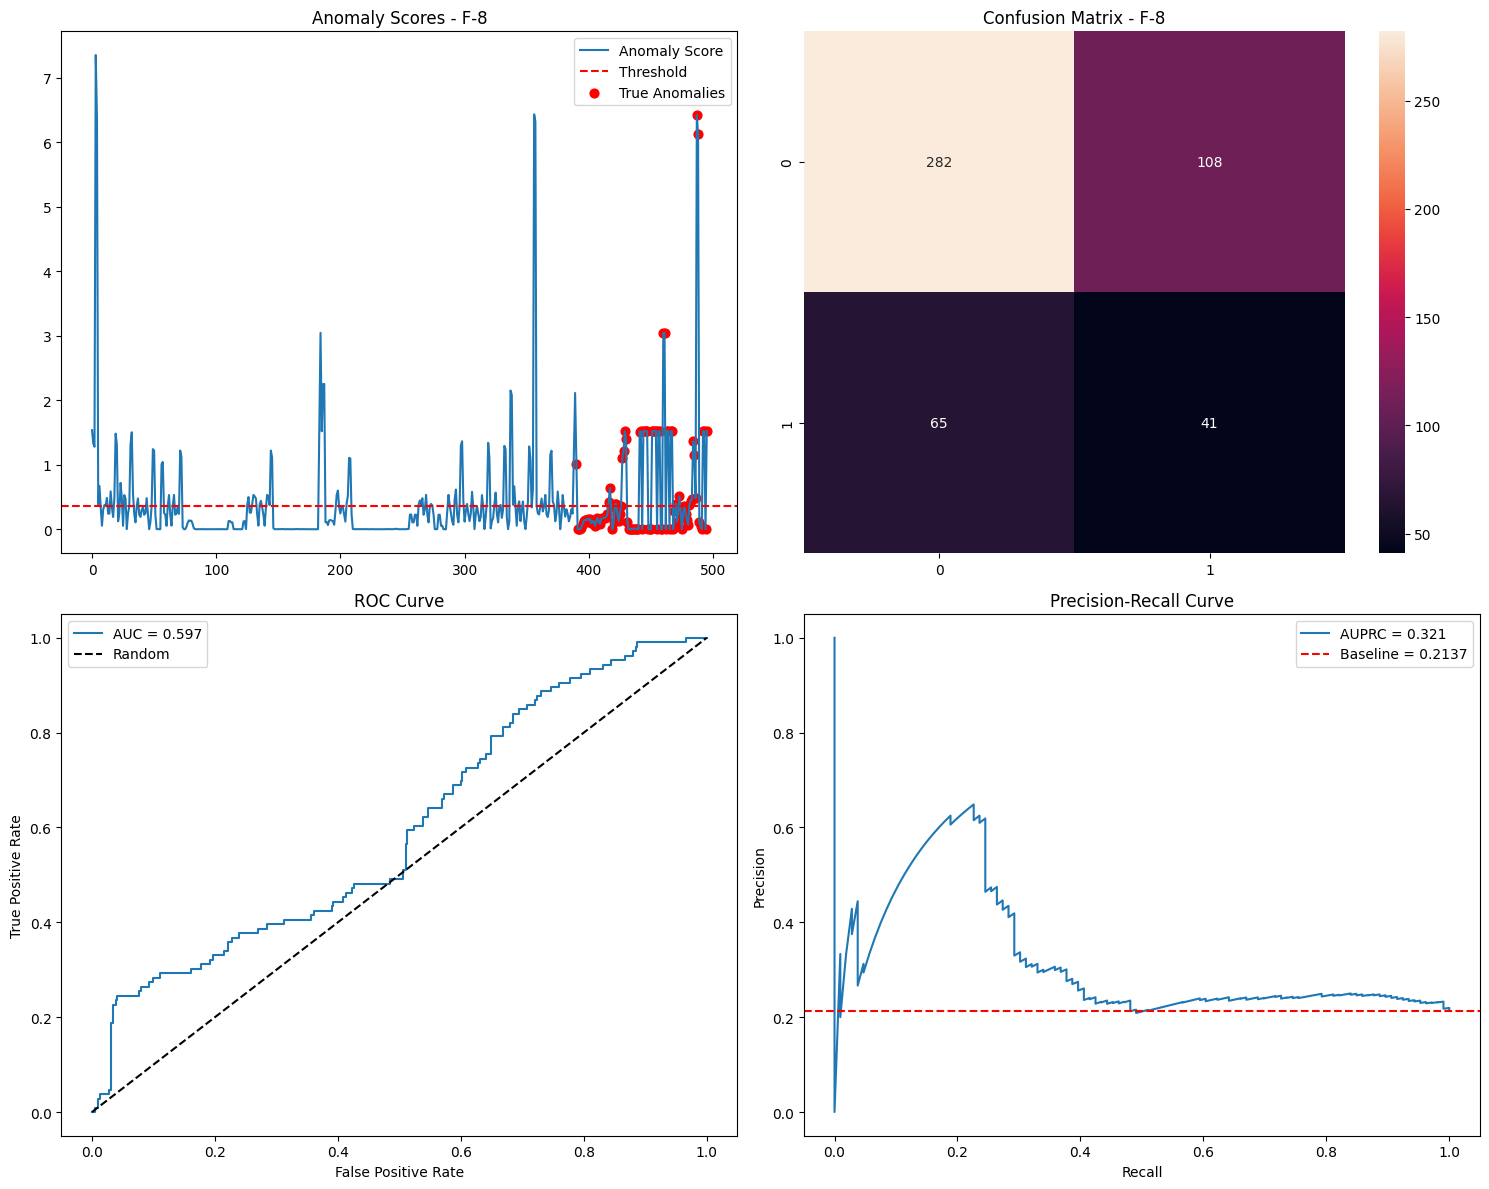


Metrics:
Accuracy: 0.651
Precision: 0.275
Recall: 0.387
F1: 0.322
AUROC: 0.597
AUPRC: 0.321 (Baseline: 0.2137)

Processing channel G-1
Channel G-1:
Total windows: 1692
Anomaly windows: 25
Anomaly class: 25    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-1
Found only 25 anomaly windows (minimum 100 required)

Processing channel G-2
Channel G-2:
Total windows: 1471
Anomaly windows: 9
Anomaly class: 26    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-2
Found only 9 anomaly windows (minimum 100 required)

Processing channel G-3
Channel G-3:
Total windows: 1580
Anomaly windows: 11
Anomaly class: 32    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-3
Found only 11 anomaly windows (minimum 100 required)

Processing channel G-4
Channel G-4:
Total windows: 1525
Anomaly windows: 7
Anomaly class: 38    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-4
Found only 7 anomaly windows (minimum 100 required)

Proces

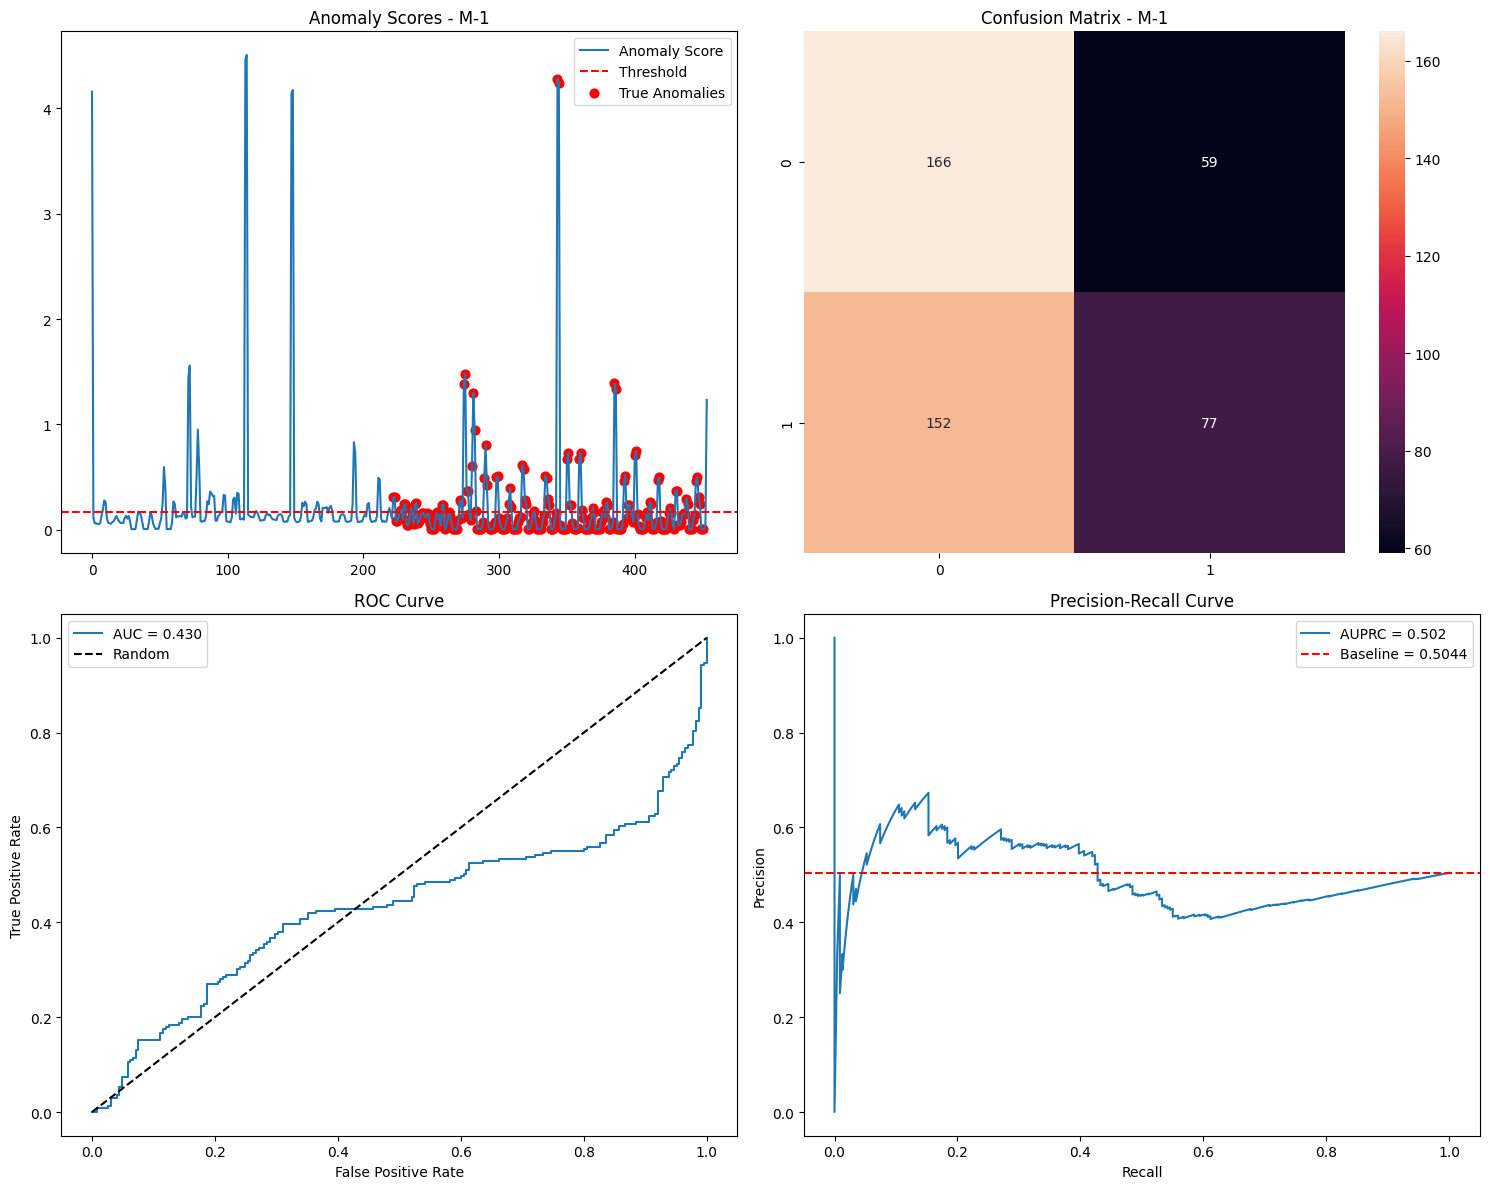


Metrics:
Accuracy: 0.535
Precision: 0.566
Recall: 0.336
F1: 0.422
AUROC: 0.430
AUPRC: 0.502 (Baseline: 0.5044)

Processing channel M-2
Channel M-2:
Total windows: 454
Anomaly windows: 229
Anomaly class: 57    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.4236, Val Loss: 0.2402
Epoch 2, Train Loss: 0.2866, Val Loss: 0.2176
Epoch 3, Train Loss: 0.2619, Val Loss: 0.2121
Epoch 4, Train Loss: 0.2552, Val Loss: 0.2091
Epoch 5, Train Loss: 0.2522, Val Loss: 0.2077
Epoch 6, Train Loss: 0.2511, Val Loss: 0.2074
Epoch 7, Train Loss: 0.2505, Val Loss: 0.2065
Epoch 8, Train Loss: 0.2503, Val Loss: 0.2064
Epoch 9, Train Loss: 0.2499, Val Loss: 0.2065
Epoch 10, Train Loss: 0.2499, Val Loss: 0.2066
Epoch 11, Train Loss: 0.2496, Val Loss: 0.2058
Epoch 12, Train Loss: 0.2498, Val Loss: 0.2062
Epoch 13, Train Loss: 0.2498, Val Loss: 0.2065
Epoch 14, Train Loss: 0.2496, Val Loss: 0.2066
Epoch 15, Train Loss: 0.2494, Val Loss: 0.2058
Epoch 16, Train Loss: 0.2496, Val Loss: 0.2058
Epoch 1

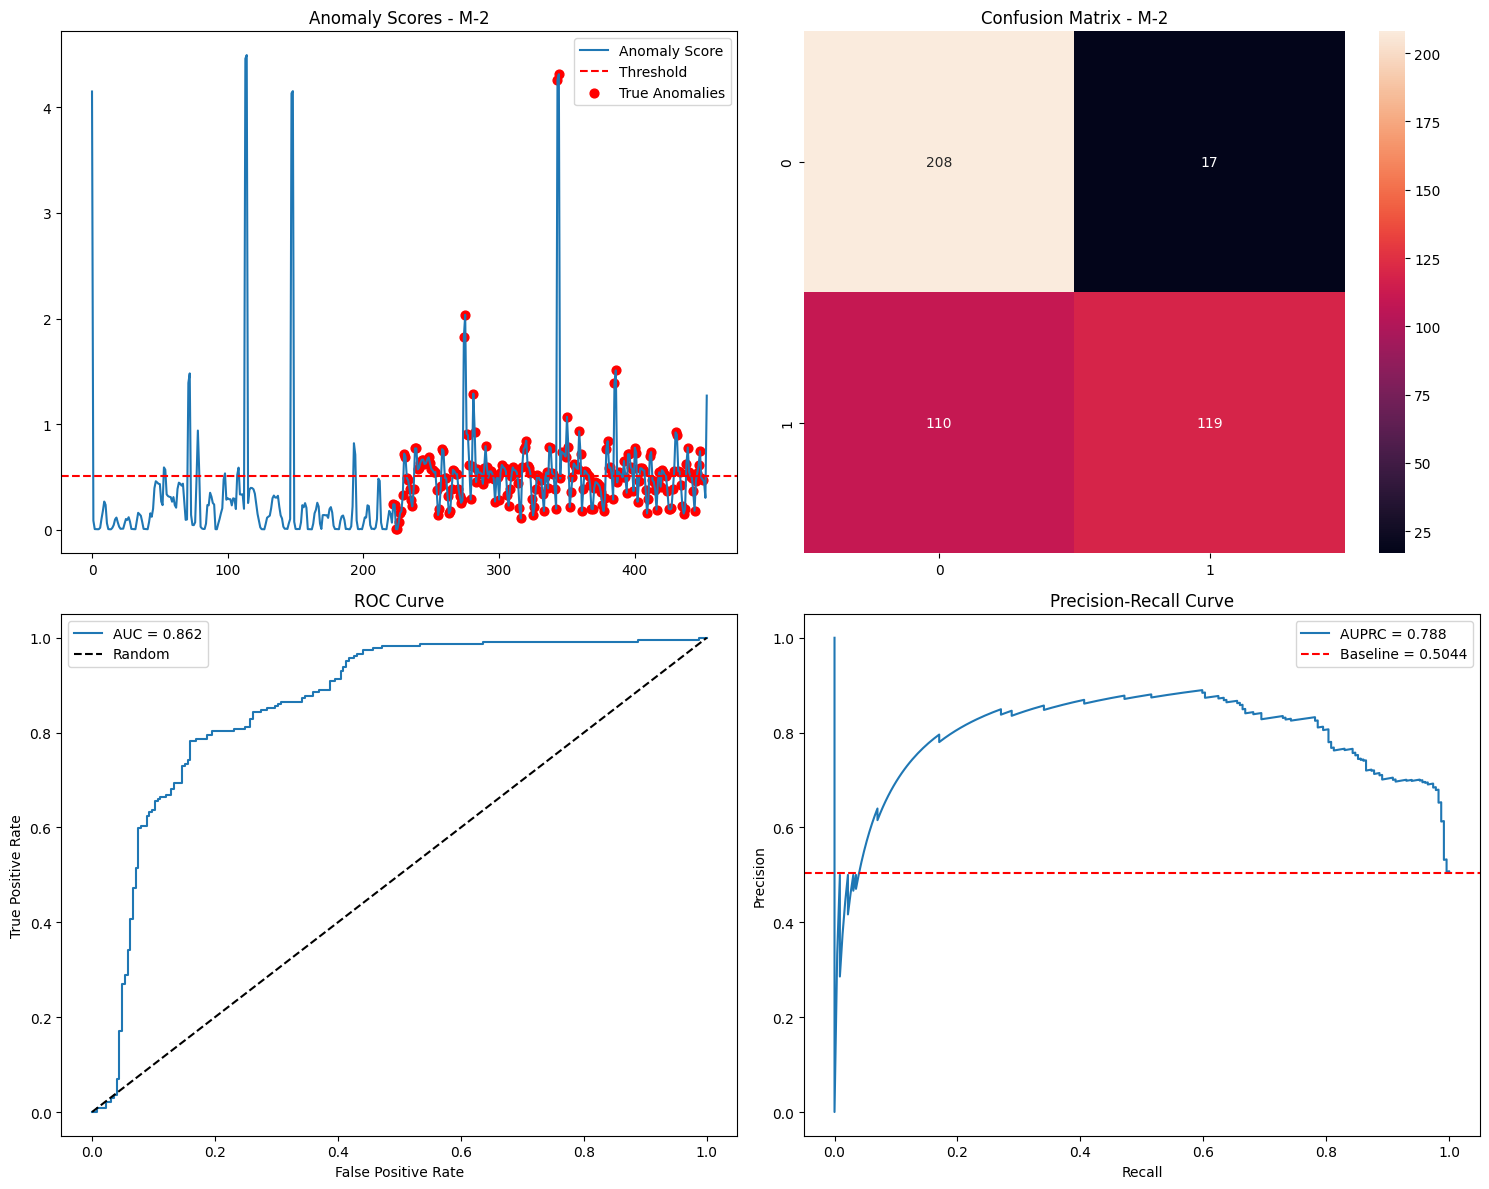


Metrics:
Accuracy: 0.720
Precision: 0.875
Recall: 0.520
F1: 0.652
AUROC: 0.862
AUPRC: 0.788 (Baseline: 0.5044)

Processing channel M-3
Channel M-3:
Total windows: 424
Anomaly windows: 51
Anomaly class: 63    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-3
Found only 51 anomaly windows (minimum 100 required)

Processing channel M-4
Channel M-4:
Total windows: 406
Anomaly windows: 51
Anomaly class: 64    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-4
Found only 51 anomaly windows (minimum 100 required)

Processing channel M-5
Channel M-5:
Total windows: 459
Anomaly windows: 61
Anomaly class: 65    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-5
Found only 61 anomaly windows (minimum 100 required)

Processing channel M-6
Channel M-6:
Total windows: 408
Anomaly windows: 37
Anomaly class: 55    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-6
Found only 37 anomaly windows (minimum 100 require

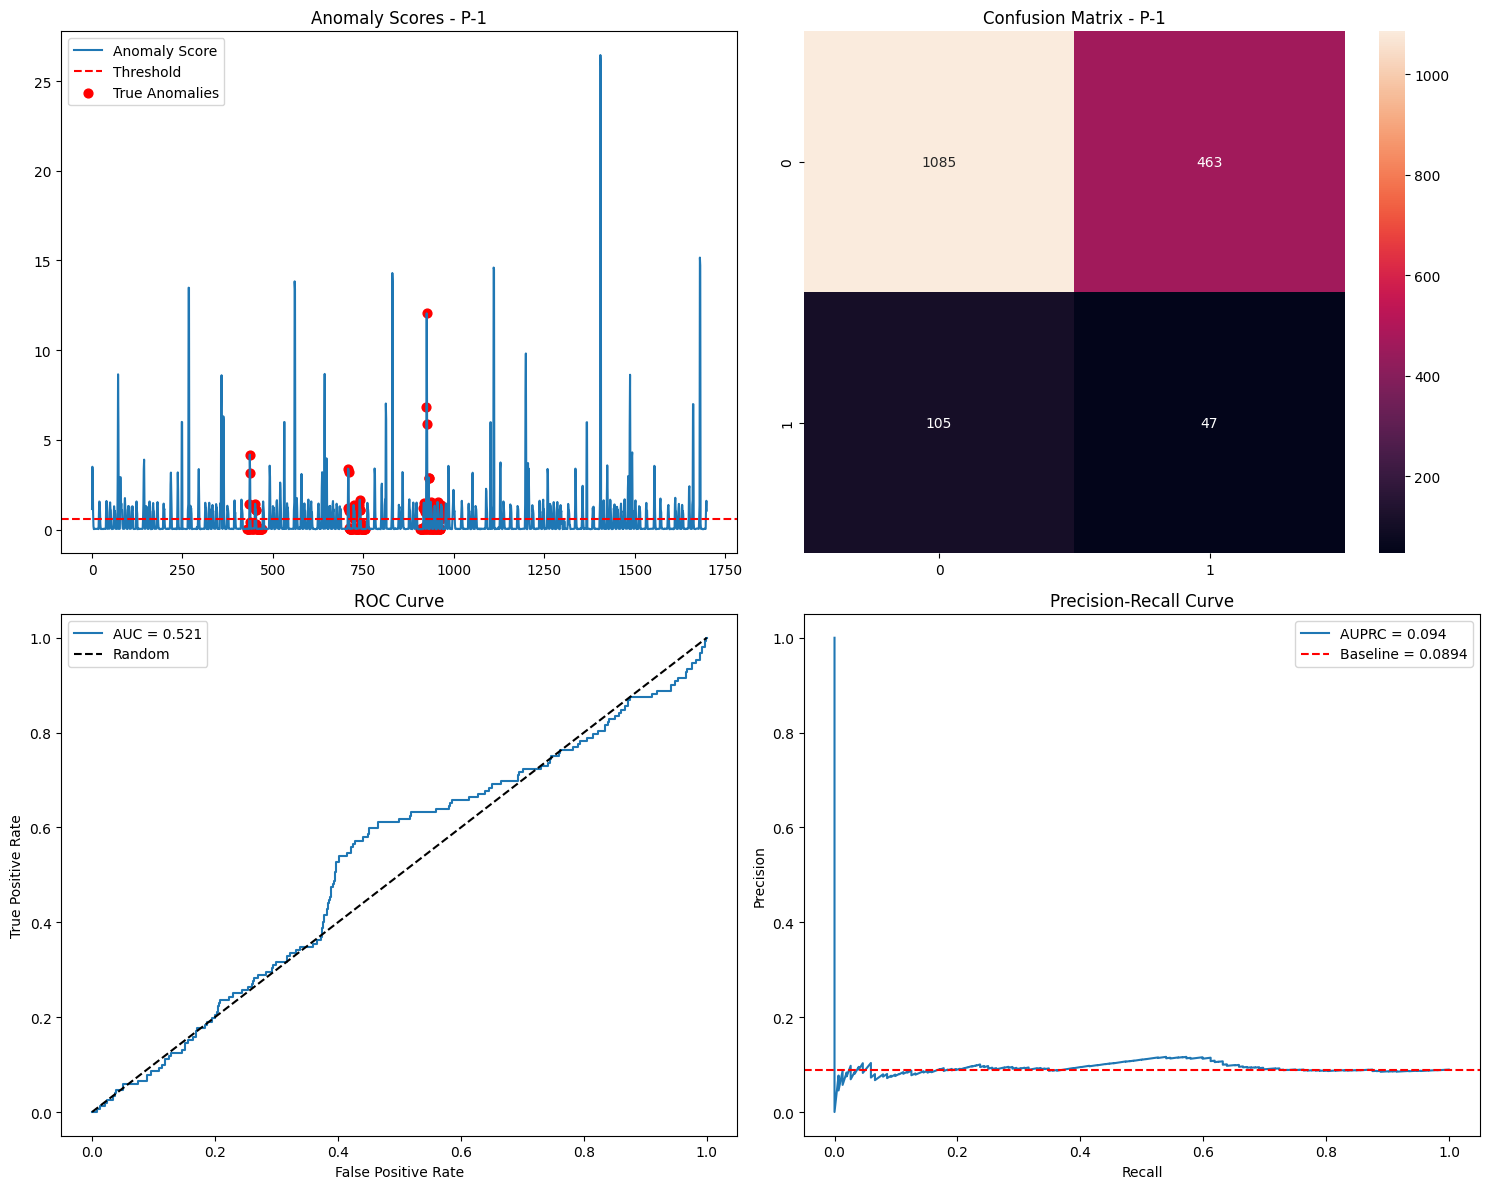


Metrics:
Accuracy: 0.666
Precision: 0.092
Recall: 0.309
F1: 0.142
AUROC: 0.521
AUPRC: 0.094 (Baseline: 0.0894)

Processing channel P-10
Channel P-10:
Total windows: 1219
Anomaly windows: 27
Anomaly class: 59    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-10
Found only 27 anomaly windows (minimum 100 required)

Processing channel P-11
Channel P-11:
Total windows: 706
Anomaly windows: 47
Anomaly class: 77    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-11
Found only 47 anomaly windows (minimum 100 required)

Processing channel P-14
Channel P-14:
Total windows: 1219
Anomaly windows: 37
Anomaly class: 75    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-14
Found only 37 anomaly windows (minimum 100 required)

Processing channel P-15
Channel P-15:
Total windows: 570
Anomaly windows: 5
Anomaly class: 66    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-15
Found only 5 anomaly windows (minimum 100 req

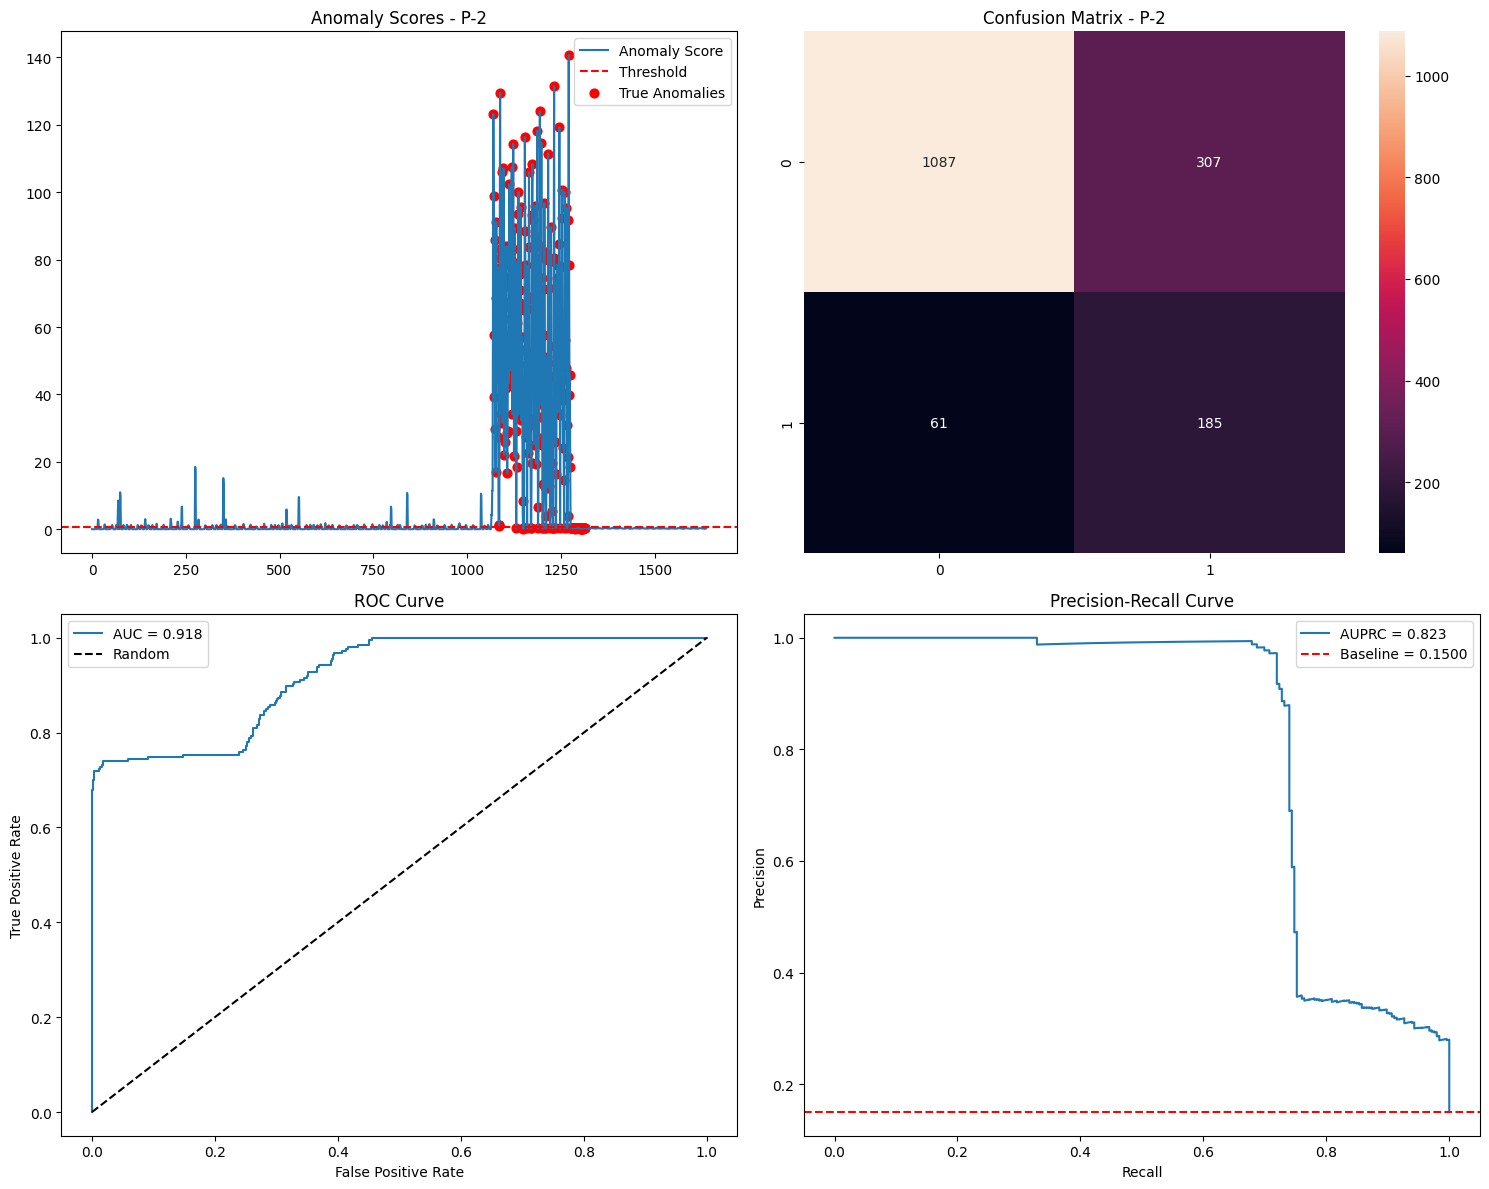


Metrics:
Accuracy: 0.776
Precision: 0.376
Recall: 0.752
F1: 0.501
AUROC: 0.918
AUPRC: 0.823 (Baseline: 0.1500)

Processing channel P-3
Channel P-3:
Total windows: 1697
Anomaly windows: 268
Anomaly class: 18    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.8683, Val Loss: 0.6803
Epoch 2, Train Loss: 0.7412, Val Loss: 0.6658
Epoch 3, Train Loss: 0.7209, Val Loss: 0.6651
Epoch 4, Train Loss: 0.7266, Val Loss: 0.6630
Epoch 5, Train Loss: 0.7139, Val Loss: 0.6604
Epoch 6, Train Loss: 0.7873, Val Loss: 0.6634
Epoch 7, Train Loss: 0.7073, Val Loss: 0.6625
Epoch 8, Train Loss: 0.7687, Val Loss: 0.6612
Epoch 9, Train Loss: 0.7121, Val Loss: 0.6622
Epoch 10, Train Loss: 0.7218, Val Loss: 0.6614
Epoch 11, Train Loss: 0.7039, Val Loss: 0.6629
Epoch 12, Train Loss: 0.7093, Val Loss: 0.6621
Epoch 13, Train Loss: 0.7508, Val Loss: 0.6606
Epoch 14, Train Loss: 0.7433, Val Loss: 0.6630
Epoch 15, Train Loss: 0.7221, Val Loss: 0.6624
Early stopping!


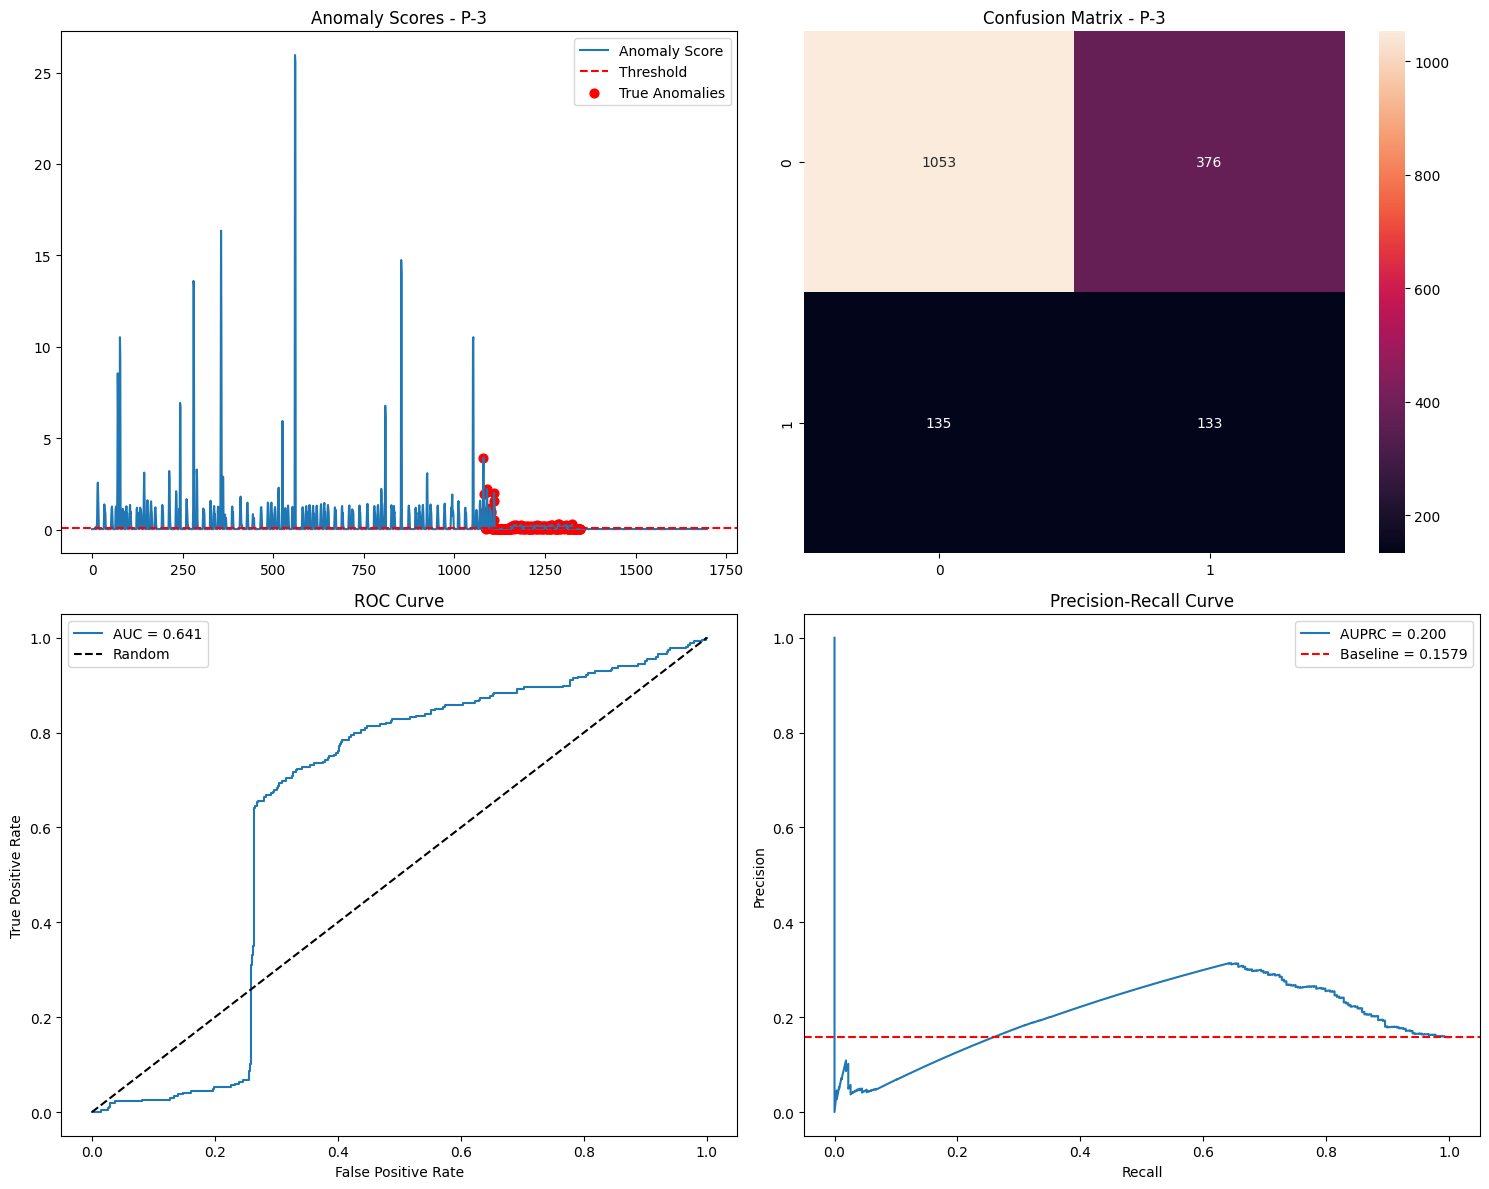


Metrics:
Accuracy: 0.699
Precision: 0.261
Recall: 0.496
F1: 0.342
AUROC: 0.641
AUPRC: 0.200 (Baseline: 0.1579)

Processing channel P-4
Channel P-4:
Total windows: 1555
Anomaly windows: 91
Anomaly class: 31    [point, point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-4
Found only 91 anomaly windows (minimum 100 required)

Processing channel P-7
Channel P-7:
Total windows: 1613
Anomaly windows: 331
Anomaly class: 45    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.4165, Val Loss: 0.2189
Epoch 2, Train Loss: 0.3812, Val Loss: 0.2084
Epoch 3, Train Loss: 0.3703, Val Loss: 0.2058
Epoch 4, Train Loss: 0.3354, Val Loss: 0.2059
Epoch 5, Train Loss: 0.3918, Val Loss: 0.2062
Epoch 6, Train Loss: 0.3245, Val Loss: 0.2070
Epoch 7, Train Loss: 0.4546, Val Loss: 0.2065
Epoch 8, Train Loss: 0.3259, Val Loss: 0.2053
Epoch 9, Train Loss: 0.3580, Val Loss: 0.2046
Epoch 10, Train Loss: 0.3229, Val Loss: 0.2056
Epoch 11, Train Loss: 0.3231, Val Loss: 0.2058
Epoch 1

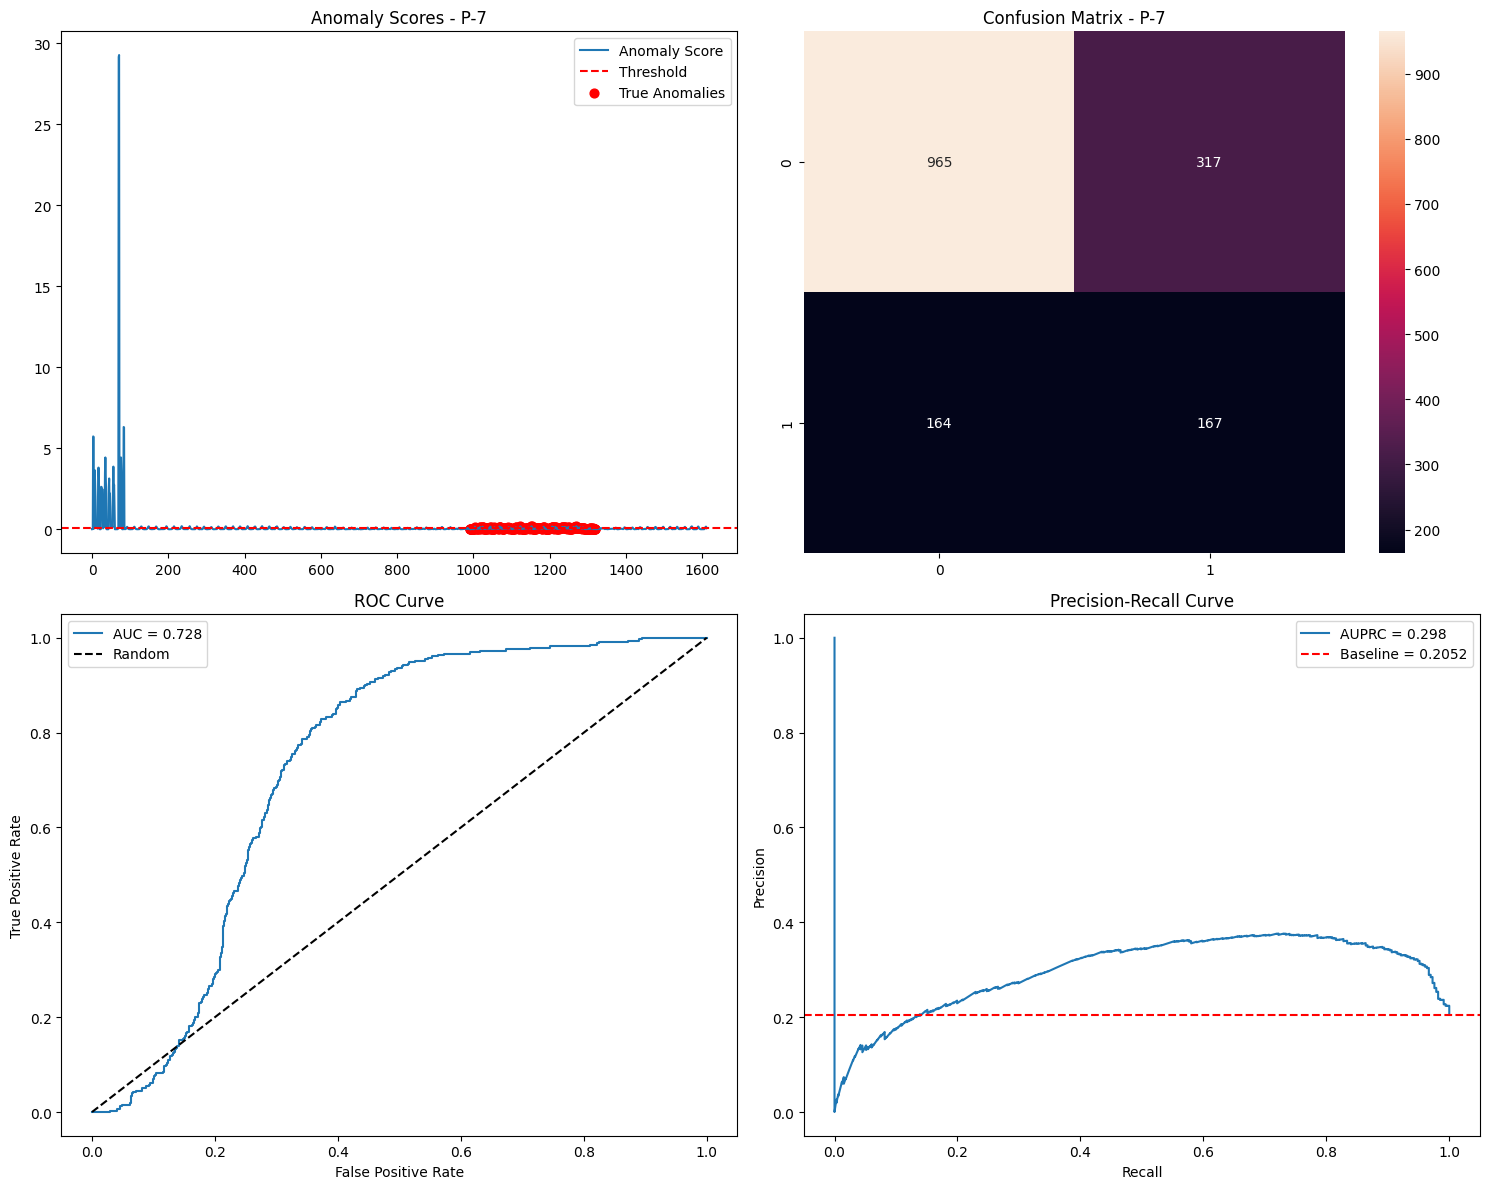


Metrics:
Accuracy: 0.702
Precision: 0.345
Recall: 0.505
F1: 0.410
AUROC: 0.728
AUPRC: 0.298 (Baseline: 0.2052)

Processing channel R-1
Channel R-1:
Total windows: 1447
Anomaly windows: 17
Anomaly class: 46    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel R-1
Found only 17 anomaly windows (minimum 100 required)

Processing channel S-1
Channel S-1:
Total windows: 1465
Anomaly windows: 90
Anomaly class: 1    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel S-1
Found only 90 anomaly windows (minimum 100 required)

Processing channel S-2
Channel S-2:
Total windows: 364
Anomaly windows: 3
Anomaly class: 58    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel S-2
Found only 3 anomaly windows (minimum 100 required)

Processing channel T-1
Channel T-1:
Total windows: 1721
Anomaly windows: 309
Anomaly class: 33    [point, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.1538, Val Loss: 0.0428
Epoch 2, Train Loss: 0.0943, Val Loss: 0

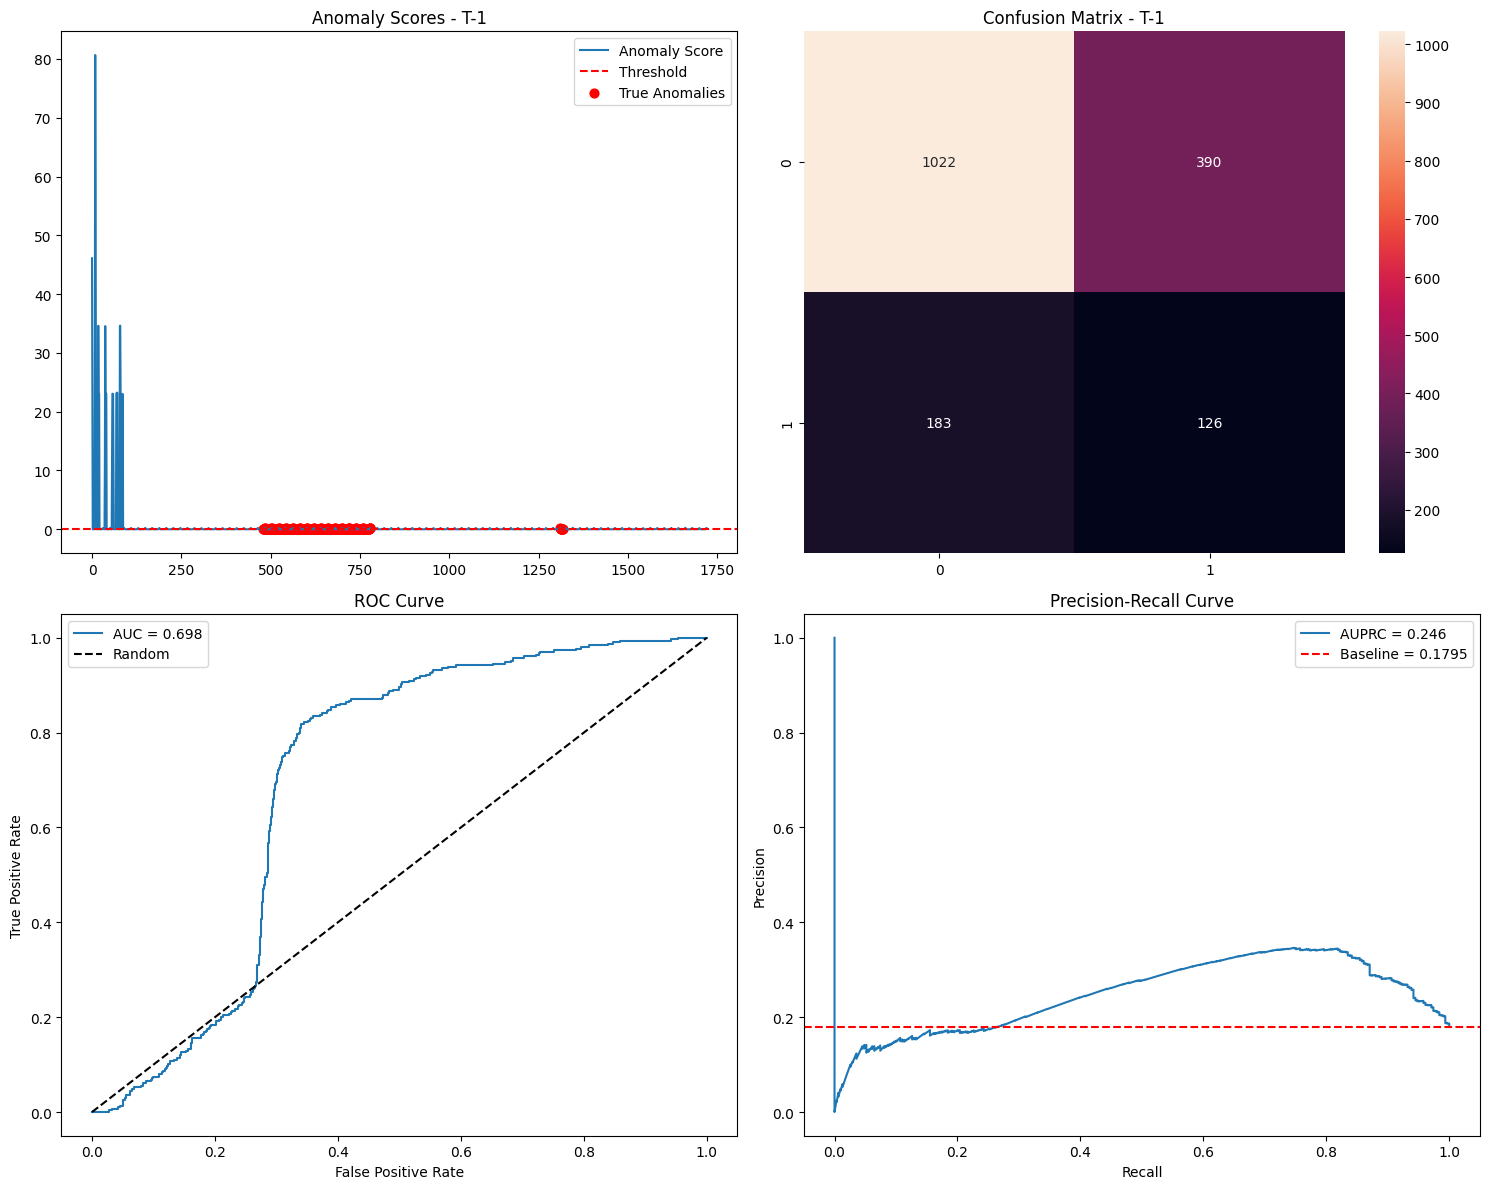


Metrics:
Accuracy: 0.667
Precision: 0.244
Recall: 0.408
F1: 0.305
AUROC: 0.698
AUPRC: 0.246 (Baseline: 0.1795)

Processing channel T-10

⚠️ WARNING: No labels found for channel T-10
→ Skipping channel

Processing channel T-12
Channel T-12:
Total windows: 485
Anomaly windows: 25
Anomaly class: 69    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-12
Found only 25 anomaly windows (minimum 100 required)

Processing channel T-13
Channel T-13:
Total windows: 485
Anomaly windows: 52
Anomaly class: 70    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-13
Found only 52 anomaly windows (minimum 100 required)

Processing channel T-2
Channel T-2:
Total windows: 1724
Anomaly windows: 356
Anomaly class: 34    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.6434, Val Loss: 0.5375
Epoch 2, Train Loss: 0.5961, Val Loss: 0.5164
Epoch 3, Train Loss: 0.5866, Val Loss: 0.5121
Epoch 4, Train Loss: 0.5482, Val Loss: 0.5099
Epoch 5, Train

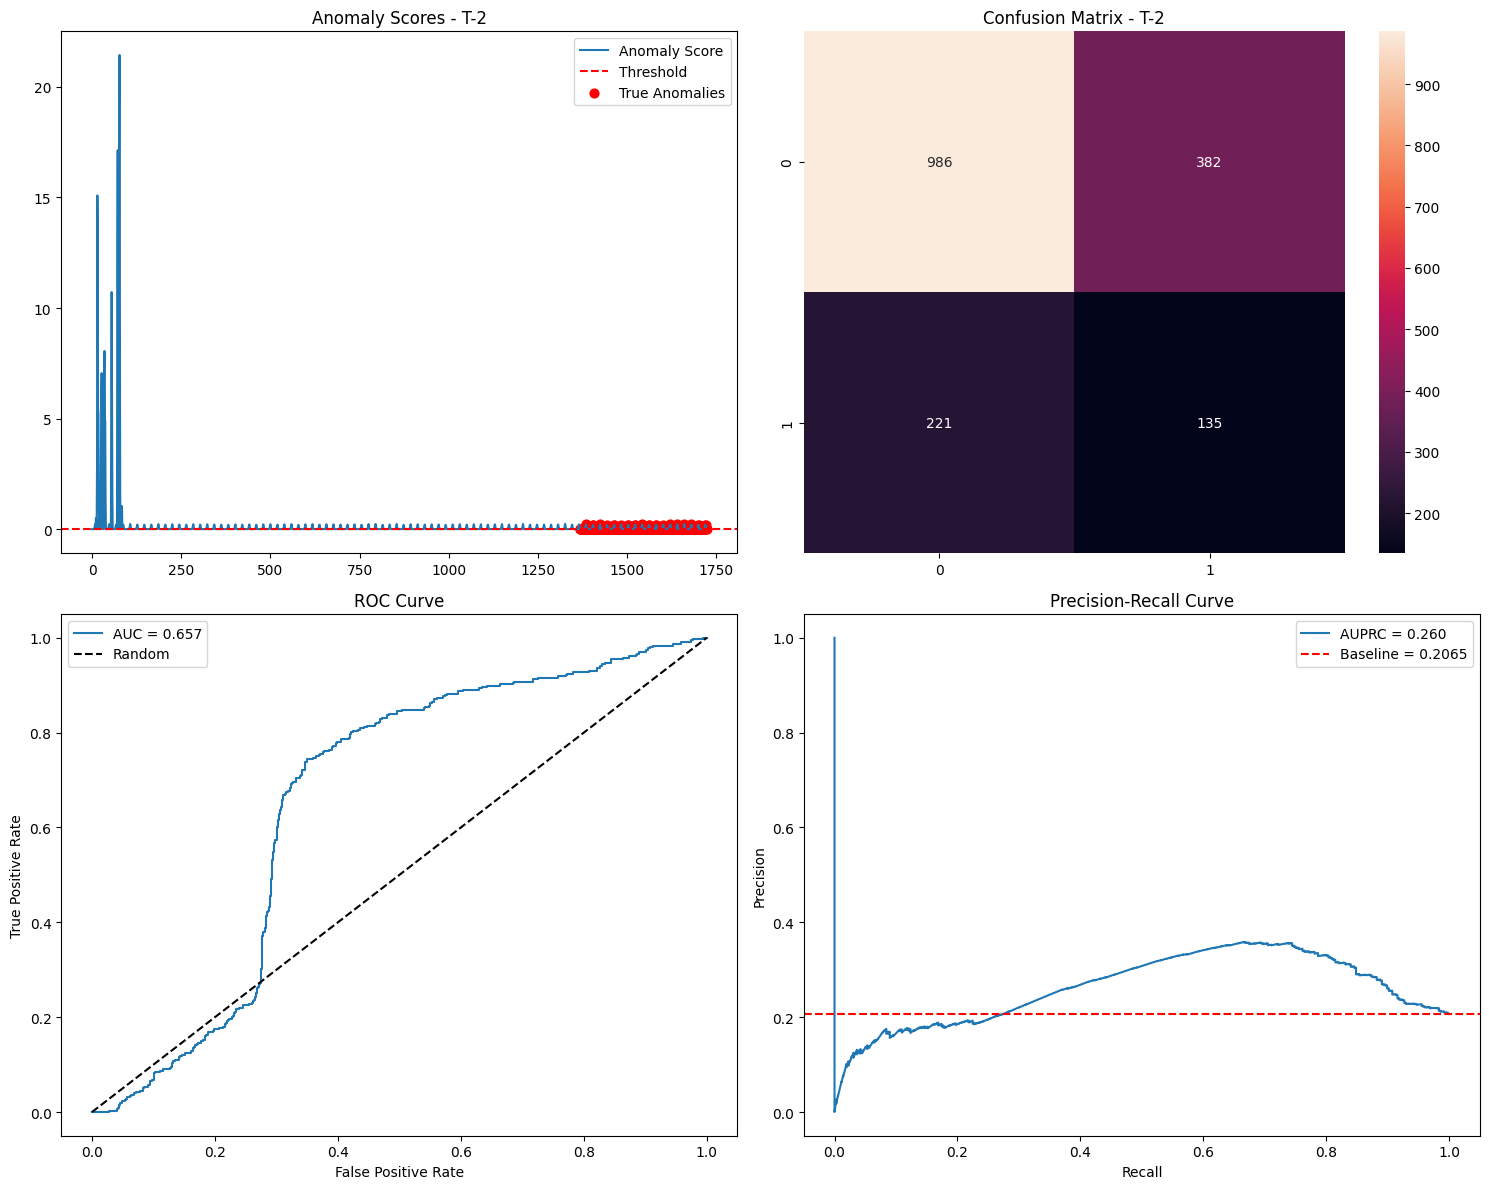


Metrics:
Accuracy: 0.650
Precision: 0.261
Recall: 0.379
F1: 0.309
AUROC: 0.657
AUPRC: 0.260 (Baseline: 0.2065)

Processing channel T-3
Channel T-3:
Total windows: 1714
Anomaly windows: 39
Anomaly class: 39    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-3
Found only 39 anomaly windows (minimum 100 required)

Processing channel T-4
Channel T-4:
Total windows: 442
Anomaly windows: 15
Anomaly class: 60    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-4
Found only 15 anomaly windows (minimum 100 required)

Processing channel T-5
Channel T-5:
Total windows: 442
Anomaly windows: 6
Anomaly class: 61    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-5
Found only 6 anomaly windows (minimum 100 required)

Processing channel T-8
Channel T-8:
Total windows: 302
Anomaly windows: 22
Anomaly class: 76    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-8
Found only 22 anomaly windows (minimum 100

In [20]:
if __name__ == "__main__":
    
       results = process_all_channels(base_path)

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score

def compute_lstm_vae_metrics(results):
    """
    Compute average metrics across all channels for the LSTM-VAE model.
    """
    # Collect metrics for each channel
    channel_metrics = []
    
    for channel, result in results.items():
        scores = result['scores']
        predictions = result['predictions']
        labels = result['labels']
        
        # Calculate metrics
        precision = precision_score(labels, predictions, zero_division=0)
        recall = recall_score(labels, predictions, zero_division=0)
        f1 = f1_score(labels, predictions, zero_division=0)
        accuracy = accuracy_score(labels, predictions)
        auroc = roc_auc_score(labels, scores)
        auprc = average_precision_score(labels, scores)
        
        channel_metrics.append({
            'channel': channel,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'auroc': auroc,
            'auprc': auprc
        })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(channel_metrics)
    
    # Calculate and add average row
    avg_metrics = metrics_df.drop('channel', axis=1).mean().to_dict()
    avg_metrics['channel'] = 'AVERAGE'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)
    
    # Format floating point numbers
    float_cols = ['precision', 'recall', 'f1', 'accuracy', 'auroc', 'auprc']
    metrics_df[float_cols] = metrics_df[float_cols].applymap(lambda x: f"{x:.4f}")
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"LSTM-VAE Model: Average Metrics Across {len(channel_metrics)} Channels")
    print(f"{'='*50}")
    print(f"Precision: {float(avg_metrics['precision']):.4f}")
    print(f"Recall: {float(avg_metrics['recall']):.4f}")
    print(f"F1-Score: {float(avg_metrics['f1']):.4f}")
    print(f"Accuracy: {float(avg_metrics['accuracy']):.4f}")
    print(f"AUROC: {float(avg_metrics['auroc']):.4f}")
    print(f"AUPRC: {float(avg_metrics['auprc']):.4f}")
    
    return metrics_df


  

# Calculate average metrics
metrics_df = compute_lstm_vae_metrics(results)

# Display full results table
print("\nDetailed metrics by channel:")
print(metrics_df.to_string(index=False))




LSTM-VAE Model: Average Metrics Across 28 Channels
Precision: 0.4467
Recall: 0.4557
F1-Score: 0.4257
Accuracy: 0.6848
AUROC: 0.6783
AUPRC: 0.4544

Detailed metrics by channel:
channel precision recall     f1 accuracy  auroc  auprc
    A-7    0.1641 0.1767 0.1702   0.5194 0.3486 0.2079
    A-8    0.8207 0.5414 0.6524   0.7378 0.8426 0.7037
    A-9    0.9032 0.5920 0.7152   0.7840 0.9400 0.8159
    D-1    0.9941 0.7800 0.8741   0.9141 0.9557 0.9533
   D-12    0.9095 0.7898 0.8454   0.9001 0.9400 0.9052
   D-15    0.3643 0.3643 0.3643   0.6186 0.6422 0.3682
   D-16    0.3664 0.3664 0.3664   0.6201 0.5296 0.3540
    D-2    0.4922 0.3006 0.3733   0.5035 0.6944 0.5822
    D-3    0.9498 0.7500 0.8382   0.8900 0.9663 0.8617
    D-4    1.0000 0.7840 0.8789   0.9173 0.9979 0.9975
    D-7    0.3646 0.3098 0.3350   0.5658 0.6803 0.4370
    D-9    0.4257 0.8217 0.5608   0.8000 0.8633 0.5585
    E-1    0.0313 0.1553 0.0521   0.6580 0.5595 0.0668
   E-12    0.0412 0.1780 0.0669   0.6555 0.3665 0.051